In [1]:
import operator
from pprint import pprint
import itertools
import re
import numpy as np

from SolrClient import SolrClient

import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import matutils

import pyLDAvis.gensim

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline

D:\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
pyLDAvis.enable_notebook()

In [3]:
solr = SolrClient('http://192.168.200.112:8983')

In [4]:
query_def = {
            'q': '-ctr_id:id_document_spell',
            'indent': 'true',
            'fl': 'ctr_id,ctr_content_nlp',
            'wt': 'json',
            'rows': '2147483647'
            }

In [5]:
res = solr.query('default',query_def)

2017-07-27 22:33:40,648 : DEBUG : Sending Request to http://192.168.200.112:8983/default/select with q=-ctr_id:id_document_spell, indent=false, fl=ctr_id,ctr_content_nlp, wt=json, rows=2147483647
2017-07-27 22:33:40,653 : DEBUG : Starting new HTTP connection (1): 192.168.200.112
2017-07-27 22:33:40,722 : DEBUG : http://192.168.200.112:8983 "POST /default/select?q=-ctr_id%3Aid_document_spell&indent=false&fl=ctr_id%2Cctr_content_nlp&wt=json&rows=2147483647 HTTP/1.1" 200 None
2017-07-27 22:33:50,549 : DEBUG : Request Completed in 9.9 Seconds


In [6]:
res.get_results_count()

41283

In [7]:
def process_texts(docs, text_fields, language='portuguese'):
    """
    Function to process texts. Following are the steps we take:

    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).

    Parameters:
    ----------
    texts: Tokenized texts.

    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = []
    for doc in docs:
        text = None
        for text_field in text_fields:
            if text_field in doc:
                text = gensim.utils.simple_preprocess(doc[text_field], deacc=False, min_len=3)
                texts.append(text)
    stops = set(stopwords.words(language))
    texts = [[word for word in text if word not in stops] for text in texts]
    
    phrases = gensim.models.Phrases(texts)
    bigram = gensim.models.phrases.Phraser(phrases)
    
    for idx in range(len(texts)):
        for token in bigram[texts[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                texts[idx].append(token)
    
    return texts

In [8]:
%%time
train_texts = process_texts(res.docs, ['ctr_content_nlp'])

2017-07-27 22:34:29,895 : INFO : collecting all words and their counts
2017-07-27 22:34:29,895 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2017-07-27 22:34:30,843 : INFO : PROGRESS: at sentence #10000, processed 628115 words and 300186 word types
2017-07-27 22:34:31,864 : INFO : PROGRESS: at sentence #20000, processed 1306750 words and 507904 word types
2017-07-27 22:34:32,817 : INFO : PROGRESS: at sentence #30000, processed 1887305 words and 724793 word types
2017-07-27 22:34:33,602 : INFO : PROGRESS: at sentence #40000, processed 2402761 words and 895731 word types
2017-07-27 22:34:33,712 : INFO : collected 913778 word types from a corpus of 2463567 words (unigram + bigrams) and 41283 sentences
2017-07-27 22:34:33,714 : INFO : using 913778 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2017-07-27 22:34:33,716 : INFO : source_vocab length 913778
2017-07-27 22:34:43,138 : INFO : Phraser built with 11441 11441 phrasegr

Wall time: 24.7 s


In [9]:
len(train_texts)

41283

In [10]:
str(train_texts[0])

"['junho', 'tecnologia', 'tecnologia', 'informação', 'comunicação', 'experiência', 'publicar', 'informação', 'tecnologia', 'serviço', 'setor', 'excelência', 'inovação', 'ged', 'ecm', 'bpm', 'desenvolvimento', 'portal', 'empresarial', 'junho', 'tecnologia', 'tecnologia', 'informação', 'comunicação', 'experiência', 'publicar', 'informação', 'tecnologia', 'serviço', 'setor', 'excelência', 'inovação', 'cação', 'digital', 'cial', 'governo', 'ged', 'ecm', 'enterprise', 'bpm', 'portal', 'tecnologia_informação', 'informação_tecnologia', 'setor_excelência', 'inovação_ged', 'ecm_bpm', 'desenvolvimento_portal', 'tecnologia_informação', 'informação_tecnologia', 'setor_excelência', 'inovação_cação', 'digital_cial', 'governo_ged', 'ecm_enterprise']"

In [11]:
dictionary = Dictionary(train_texts)

2017-07-27 22:35:20,204 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-07-27 22:35:21,117 : INFO : adding document #10000 to Dictionary(30891 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:22,082 : INFO : adding document #20000 to Dictionary(44578 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:22,950 : INFO : adding document #30000 to Dictionary(56862 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:23,720 : INFO : adding document #40000 to Dictionary(66053 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:23,828 : INFO : built Dictionary(66863 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...) from 41283 documents (total 2826183 corpus positions)


In [12]:
print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 66863


In [13]:
dictionary.save('mp_dictionary_full.dict')

2017-07-27 22:35:33,887 : INFO : saving Dictionary object under mp_dictionary_full.dict, separately None
2017-07-27 22:35:33,920 : INFO : saved mp_dictionary_full.dict


In [14]:
dictionary_filtered = Dictionary(train_texts)
dictionary_filtered.save('mp_dictionary_filtered.dict')
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)
dictionary_filtered.filter_extremes(no_above=0.5)
print('Number of unique tokens: %d' % len(dictionary_filtered))

2017-07-27 22:35:39,166 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-07-27 22:35:40,085 : INFO : adding document #10000 to Dictionary(30891 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:41,048 : INFO : adding document #20000 to Dictionary(44578 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:41,914 : INFO : adding document #30000 to Dictionary(56862 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:42,680 : INFO : adding document #40000 to Dictionary(66053 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...)
2017-07-27 22:35:42,777 : INFO : built Dictionary(66863 unique tokens: ['junho', 'tecnologia', 'informação', 'comunicação', 'experiência']...) from 41283 documents (total 2826183 corpus positions)
2017-07-27 22:35:42,778 : INFO : saving Dictionary object under 

Number of unique tokens: 22751


In [15]:
corpus = [dictionary.doc2bow(text) for text in train_texts]
print('Number of documents on full: %d' % len(corpus))
corpus_filtered = [dictionary_filtered.doc2bow(text) for text in train_texts]
print('Number of documents on filtered: %d' % len(corpus_filtered))

Number of documents on full: 41283
Number of documents on filtered: 41283


In [17]:
%%time
ldamodel_filtered = LdaModel(corpus=corpus_filtered, num_topics=10, id2word=dictionary_filtered, chunksize=45000, passes=20, iterations=400, eval_every=1, alpha='auto', eta='auto')

2017-07-27 22:43:34,607 : INFO : using autotuned alpha, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
2017-07-27 22:43:34,613 : INFO : using serial LDA version on this node
2017-07-27 22:43:35,850 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-07-27 22:43:37,712 : DEBUG : bound: at document #0
2017-07-27 22:50:45,906 : INFO : -10.707 per-word bound, 1672.0 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-27 22:50:45,906 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-07-27 22:50:45,906 : DEBUG : performing inference on a chunk of 41283 documen

2017-07-27 23:10:46,745 : INFO : topic diff=0.424524, rho=0.447214
2017-07-27 23:10:47,284 : DEBUG : bound: at document #0
2017-07-27 23:13:38,204 : INFO : -7.297 per-word bound, 157.3 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-27 23:13:38,204 : INFO : PROGRESS: pass 4, at document #41283/41283
2017-07-27 23:13:38,204 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-27 23:14:40,532 : DEBUG : 41275/41283 documents converged within 400 iterations
2017-07-27 23:14:41,305 : INFO : optimized alpha [0.045251002781226367, 0.043903028190714552, 0.053412269169971216, 0.044309195235710745, 0.044890271285409893, 0.055866782337922805, 0.059427230585255925, 0.051763749277996006, 0.064600815450115354, 0.043803306012486769]
2017-07-27 23:14:41,305 : DEBUG : updating topics
2017-07-27 23:14:41,630 : INFO : topic #9 (0.044): 0.028*"válido" + 0.014*"campo" + 0.012*"sábado" + 0.008*"ano" + 0.008*"abril" + 0.008*"maio" + 0.008*"justiça"

2017-07-27 23:29:05,279 : INFO : optimized alpha [0.038552638419173682, 0.037490901197711854, 0.051357979275438476, 0.038693248018335388, 0.040887692577205356, 0.050178476484768191, 0.0547405804819402, 0.04541675616368647, 0.063819936195200919, 0.039392654699114911]
2017-07-27 23:29:05,279 : DEBUG : updating topics
2017-07-27 23:29:05,522 : INFO : topic #1 (0.037): 0.016*"lei" + 0.016*"decreto" + 0.013*"pub" + 0.012*"abril" + 0.012*"portaria" + 0.011*"maio" + 0.011*"publicar" + 0.010*"janeiro" + 0.009*"brasil" + 0.009*"sergipe"
2017-07-27 23:29:05,522 : INFO : topic #0 (0.039): 0.029*"licença" + 0.027*"efp" + 0.023*"cetesb" + 0.021*"sito" + 0.019*"lei" + 0.017*"público" + 0.014*"pedido" + 0.014*"saúde" + 0.012*"tratar" + 0.011*"operação"
2017-07-27 23:29:05,537 : INFO : topic #2 (0.051): 0.023*"valor" + 0.016*"dezembro" + 0.014*"exercício" + 0.014*"ativo" + 0.013*"companhia" + 0.012*"demonstração" + 0.010*"caixa" + 0.009*"resultado" + 0.009*"ação" + 0.008*"passivo"
2017-07-27 23:29:05,

2017-07-27 23:42:40,636 : INFO : topic #0 (0.035): 0.030*"licença" + 0.028*"efp" + 0.025*"cetesb" + 0.022*"sito" + 0.019*"lei" + 0.018*"público" + 0.014*"pedido" + 0.014*"saúde" + 0.013*"tratar" + 0.012*"operação"
2017-07-27 23:42:40,636 : INFO : topic #2 (0.050): 0.023*"valor" + 0.016*"dezembro" + 0.015*"exercício" + 0.014*"companhia" + 0.013*"ativo" + 0.013*"demonstração" + 0.010*"caixa" + 0.009*"ação" + 0.009*"resultado" + 0.008*"passivo"
2017-07-27 23:42:40,646 : INFO : topic #6 (0.053): 0.037*"item" + 0.025*"preço" + 0.022*"valor" + 0.014*"empresa" + 0.014*"merc" + 0.012*"edital" + 0.012*"proposta" + 0.010*"processo" + 0.009*"aquisição" + 0.009*"unidade"
2017-07-27 23:42:40,647 : INFO : topic #8 (0.063): 0.015*"objeto" + 0.014*"processo" + 0.013*"prazo" + 0.012*"valor" + 0.012*"hora" + 0.011*"empresa" + 0.010*"contrato" + 0.010*"termo" + 0.008*"lei" + 0.008*"edital"
2017-07-27 23:42:40,650 : INFO : topic diff=0.333971, rho=0.267261
2017-07-27 23:42:41,044 : DEBUG : bound: at docum

2017-07-27 23:55:56,927 : INFO : topic #6 (0.052): 0.038*"item" + 0.025*"preço" + 0.021*"valor" + 0.015*"empresa" + 0.014*"merc" + 0.012*"edital" + 0.012*"proposta" + 0.010*"processo" + 0.009*"aquisição" + 0.009*"unidade"
2017-07-27 23:55:56,928 : INFO : topic #8 (0.063): 0.015*"objeto" + 0.014*"processo" + 0.013*"prazo" + 0.013*"valor" + 0.012*"hora" + 0.011*"empresa" + 0.011*"contrato" + 0.010*"termo" + 0.008*"lei" + 0.008*"assinatura"
2017-07-27 23:55:56,932 : INFO : topic diff=0.310421, rho=0.235702
2017-07-27 23:55:57,297 : DEBUG : bound: at document #0
2017-07-27 23:58:29,027 : INFO : -7.141 per-word bound, 141.1 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-27 23:58:29,027 : INFO : PROGRESS: pass 17, at document #41283/41283
2017-07-27 23:58:29,027 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-27 23:59:13,705 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-27 23:59:14,476 : INFO : optim

Wall time: 1h 22min 14s


In [18]:
pyLDAvis.gensim.prepare(ldamodel_filtered, corpus_filtered, dictionary_filtered)

2017-07-28 06:09:40,189 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 06:10:22,049 : DEBUG : 41283/41283 documents converged within 400 iterations
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      19.055493        1       1 -0.175819  0.013270
8      17.081760        1       2 -0.061174  0.084170
6      12.271089        1       3 -0.089572  0.177646
4      11.475648        1       4 -0.053959  0.105974
5      10.923700        1       5  0.125320 -0.024217
3      10.248249        1       6 -0.112016 -0.203810
7       7.224972        1       7 -0.049672  0.043886
0       4.971096        1       8  0.231631 -0.103898
9       3.607538        1       9  0.234001  0.109746
1       3.140455        1      10 -0.048740 -0.202768, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
5660   Default  11425.000000      candidato  11425.000000  30.0000  30.0000
186    Default  24546.000000            lei  24546.000000  29.0000  29.0000
310    Default  17440.000000           item  17440.000000  28.0000  28.0000
1916   Default  14599.000000        decreto  14599.000000  27.0000  27.0000
592    Default   9836.000000          preço   9836.000000  26.0000  26.0000
848    Default   5177.000000        licença   5177.000000  25.0000  25.0000
5619   Default   7530.000000      inscrição   7530.000000  24.0000  24.0000
19642  Default   5733.000000         estado   5733.000000  23.0000  23.0000
8589   Default   3987.000000         válido   3987.000000  22.0000  22.0000
35     Default  14904.000000       dezembro  14904.000000  21.0000  21.0000
116    Default  15701.000000        período  15701.000000  20.0000  20.0000
18689  Default   3932.000000            efp   3932.000000  19.0000  19.0000
5658   Default   5493.000000        sergipe   5493.000000  18.0000  18.0000
113    Default   7154.000000          ativo   7154.000000  17.0000  17.0000
182    Default  20587.000000          termo  20587.000000  16.0000  16.0000
852    Default   4407.000000           sito   4407.000000  15.0000  15.0000
846    Default   3430.000000         cetesb   3430.000000  14.0000  14.0000
85     Default   8488.000000      companhia   8488.000000  13.0000  13.0000
51     Default   6709.000000   demonstração   6709.000000  12.0000  12.0000
570    Default  11435.000000         edital  11435.000000  11.0000  11.0000
4606   Default   4500.000000           merc   4500.000000  10.0000  10.0000
609    Default  10622.000000         objeto  10622.000000   9.0000   9.0000
153    Default  13319.000000        empresa  13319.000000   8.0000   8.0000
67     Default  28679.000000          valor  28679.000000   7.0000   7.0000
2435   Default   6340.000000       portaria   6340.000000   6.0000   6.0000
5      Default  10398.000000       publicar  10398.000000   5.0000   5.0000
10162  Default   3701.000000            peb   3701.000000   4.0000   4.0000
141    Default   5953.000000       operação   5953.000000   3.0000   3.0000
844    Default   3979.000000        público   3979.000000   2.0000   2.0000
6202   Default   4027.000000       concurso   4027.000000   1.0000   1.0000
...        ...           ...            ...           ...      ...      ...
1074   Topic10    544.830223          texto    945.880348   2.9092  -5.0536
4666   Topic10    260.818621    integrantes    352.489416   3.1596  -5.7902
12173  Topic10    254.802221  meio_portaria    346.481404   3.1535  -5.8136
16273  Topic10    500.453323         membro   1199.915904   2.5863  -5.1386
2435   Topic10   1324.042748       portaria   6340.211353   1.8946  -4.1656
190    Topic10    499.974167         edição   1364.420611   2.4569  -5.1395
192    Topic10    579.058394         página   1903.978453   2.2705  -4.9927
130    Topic10    404.629999         imóvel   1065.189064   2.4929  -5.3511
1916   Topic10   1429.704192        decreto  14599.526514   1.1373  -4.0889
1053   Topic10    523.467786        arquivo   1959.939507   2.1406  -5.0936
394    Topic10    334.449259         fran

In [19]:
%%time
coherence_model = CoherenceModel(model=ldamodel_filtered, texts=train_texts, dictionary=dictionary_filtered, coherence='c_v')
print(coherence_model.get_coherence())

2017-07-28 06:11:34,333 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-07-28 06:11:38,949 : INFO : 237 batches submitted to accumulate stats from 15168 documents (-570270 virtual)
2017-07-28 06:11:39,174 : INFO : 259 batches submitted to accumulate stats from 16576 documents (-623821 virtual)
2017-07-28 06:11:39,420 : INFO : 277 batches submitted to accumulate stats from 17728 documents (-641571 virtual)
2017-07-28 06:11:39,495 : INFO : 282 batches submitted to accumulate stats from 18048 documents (-643092 virtual)
2017-07-28 06:11:39,546 : INFO : 285 batches submitted to accumulate stats from 18240 documents (-643898 virtual)
2017-07-28 06:11:39,671 : INFO : 291 batches submitted to accumulate stats from 18624 documents (-644882 virtual)
2017-07-28 06:11:39,719 : INFO : 294 batches submitted to accumulate stats from 18816 documents (-644910 virtual)
2017-07-28 06:11:39,812 : INFO : 299 batches submitted

0.626145841764
Wall time: 9.02 s


In [20]:
np.arange(10, 101, 10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [21]:
def get_best_model_by_topics(dictionary, corpus, texts, limit, chunksize=20000, passes=20, iterations=200):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    # Set training parameters.
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.
    
    lm_list = {}
    co_va = {}
    for num_topics in np.arange(10, limit, 10):
        lm = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, \
                      num_topics=num_topics, chunksize=chunksize, iterations=iterations, \
                      eval_every=eval_every, alpha='auto', eta='auto')
        lm_list[num_topics - 1] = lm
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        co_va[num_topics - 1] = cm.get_coherence()
    top_models = sorted(co_va.items(), key=operator.itemgetter(1), reverse=True)
    print('Melhores 5 modelos', top_models[:5])
    return lm_list[top_models[0][0]], lm_list, co_va

In [23]:
%%time
best_model_filtered, lm_filtered, c_v_filtered = get_best_model_by_topics(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=101, passes=15, iterations=400, chunksize=45000)
print(best_model_filtered.show_topics(formatted=True))

2017-07-28 06:14:07,980 : INFO : using autotuned alpha, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
2017-07-28 06:14:07,985 : INFO : using serial LDA version on this node
2017-07-28 06:14:09,270 : INFO : running online (multi-pass) LDA training, 10 topics, 15 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-07-28 06:14:11,168 : DEBUG : bound: at document #0
2017-07-28 06:21:35,593 : INFO : -10.709 per-word bound, 1674.1 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 06:21:35,593 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-07-28 06:21:35,593 : DEBUG : performing inference on a chunk of 41283 documen

2017-07-28 06:42:18,416 : INFO : topic diff=0.430462, rho=0.447214
2017-07-28 06:42:18,960 : DEBUG : bound: at document #0
2017-07-28 06:45:11,609 : INFO : -7.306 per-word bound, 158.2 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 06:45:11,609 : INFO : PROGRESS: pass 4, at document #41283/41283
2017-07-28 06:45:11,609 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 06:46:16,210 : DEBUG : 41277/41283 documents converged within 400 iterations
2017-07-28 06:46:17,015 : INFO : optimized alpha [0.044170519673194575, 0.050218548762373957, 0.056243150354388399, 0.050142489758895022, 0.044506869117539802, 0.04701069886934324, 0.056462396947097468, 0.058859669480387074, 0.044392635989208659, 0.058358193042489709]
2017-07-28 06:46:17,015 : DEBUG : updating topics
2017-07-28 06:46:17,371 : INFO : topic #0 (0.044): 0.021*"icms" + 0.018*"decreto" + 0.015*"lei" + 0.015*"dezembro" + 0.011*"termo" + 0.009*"ponto" + 0.009*"item" 

2017-07-28 07:01:00,730 : DEBUG : 41281/41283 documents converged within 400 iterations
2017-07-28 07:01:01,537 : INFO : optimized alpha [0.03687773133250432, 0.042467731329579664, 0.054636497433898423, 0.045964050330561598, 0.038588257356147702, 0.042792263473459408, 0.052420992130068463, 0.055314758780527586, 0.039037380962845987, 0.054927589615571176]
2017-07-28 07:01:01,537 : DEBUG : updating topics
2017-07-28 07:01:01,800 : INFO : topic #0 (0.037): 0.024*"icms" + 0.021*"decreto" + 0.017*"lei" + 0.017*"dezembro" + 0.012*"termo" + 0.010*"ponto" + 0.009*"contribuinte" + 0.009*"regulamento" + 0.008*"publicar" + 0.008*"item"
2017-07-28 07:01:01,800 : INFO : topic #4 (0.039): 0.023*"válido" + 0.022*"efp" + 0.018*"protocolo" + 0.018*"assunto" + 0.017*"brasil" + 0.016*"apenso" + 0.015*"licença" + 0.013*"saúde" + 0.013*"pedido" + 0.013*"tratar"
2017-07-28 07:01:01,816 : INFO : topic #2 (0.055): 0.018*"objeto" + 0.015*"valor" + 0.014*"contrato" + 0.012*"prazo" + 0.012*"empresa" + 0.011*"pro

2017-07-28 07:15:07,753 : INFO : topic #0 (0.033): 0.025*"icms" + 0.022*"decreto" + 0.018*"dezembro" + 0.017*"lei" + 0.013*"termo" + 0.010*"ponto" + 0.010*"contribuinte" + 0.010*"regulamento" + 0.009*"publicar" + 0.008*"reincidente"
2017-07-28 07:15:07,753 : INFO : topic #4 (0.035): 0.027*"efp" + 0.026*"válido" + 0.022*"assunto" + 0.020*"protocolo" + 0.020*"apenso" + 0.015*"licença" + 0.015*"brasil" + 0.014*"saúde" + 0.014*"pedido" + 0.013*"tratar"
2017-07-28 07:15:07,753 : INFO : topic #9 (0.052): 0.025*"decreto" + 0.024*"lei" + 0.017*"termo" + 0.016*"período" + 0.013*"estado" + 0.011*"sergipe" + 0.010*"peb" + 0.010*"portaria" + 0.009*"abril" + 0.009*"disposição"
2017-07-28 07:15:07,764 : INFO : topic #7 (0.053): 0.040*"item" + 0.023*"preço" + 0.019*"valor" + 0.016*"empresa" + 0.013*"edital" + 0.013*"processo" + 0.012*"proposta" + 0.009*"aquisição" + 0.008*"pregão" + 0.008*"unidade"
2017-07-28 07:15:07,768 : INFO : topic #2 (0.054): 0.019*"objeto" + 0.015*"valor" + 0.014*"contrato" + 

2017-07-28 07:34:55,527 : INFO : topic #6 (0.040): 0.012*"valor" + 0.012*"item" + 0.012*"assunto" + 0.011*"decreto" + 0.010*"apenso" + 0.008*"brasil" + 0.008*"fevereiro" + 0.008*"icms" + 0.008*"março" + 0.007*"descrição"
2017-07-28 07:34:55,527 : INFO : topic #18 (0.043): 0.018*"termo" + 0.012*"lei" + 0.008*"período" + 0.008*"licença" + 0.008*"efp" + 0.008*"pedido" + 0.007*"processo" + 0.007*"protocolo" + 0.007*"saúde" + 0.007*"tratar"
2017-07-28 07:34:55,540 : INFO : topic #4 (0.044): 0.021*"valor" + 0.009*"lei" + 0.008*"ativo" + 0.008*"companhia" + 0.008*"ano" + 0.007*"total" + 0.006*"termo" + 0.006*"guarulhos" + 0.006*"santos" + 0.006*"dezembro"
2017-07-28 07:34:55,542 : INFO : topic #2 (0.045): 0.019*"valor" + 0.015*"lei" + 0.010*"decreto" + 0.009*"abril" + 0.008*"empresa" + 0.007*"dezembro" + 0.007*"termo" + 0.007*"exercício" + 0.006*"item" + 0.006*"brasil"
2017-07-28 07:34:55,547 : INFO : topic diff=11.273439, rho=1.000000
2017-07-28 07:34:57,008 : DEBUG : bound: at document #0
2

2017-07-28 07:54:25,540 : DEBUG : updating topics
2017-07-28 07:54:26,089 : INFO : topic #14 (0.032): 0.038*"pub" + 0.022*"vig" + 0.010*"pub_vig" + 0.009*"pub_pub" + 0.008*"unid" + 0.007*"ação" + 0.007*"valor" + 0.006*"companhia" + 0.006*"oferta" + 0.006*"item"
2017-07-28 07:54:26,089 : INFO : topic #15 (0.032): 0.020*"demonstração" + 0.018*"decisão" + 0.014*"auditoria" + 0.014*"osasco" + 0.011*"aiim" + 0.011*"processo" + 0.010*"opinião" + 0.010*"recurso" + 0.009*"lei" + 0.009*"decreto"
2017-07-28 07:54:26,089 : INFO : topic #18 (0.039): 0.028*"termo" + 0.014*"lei" + 0.013*"pedido" + 0.012*"licença" + 0.011*"saúde" + 0.010*"período" + 0.009*"tratar" + 0.009*"função" + 0.009*"efp" + 0.009*"despacho"
2017-07-28 07:54:26,102 : INFO : topic #4 (0.041): 0.030*"valor" + 0.017*"ativo" + 0.015*"companhia" + 0.014*"dezembro" + 0.010*"exercício" + 0.009*"ação" + 0.009*"demonstração" + 0.009*"total" + 0.008*"passivo" + 0.008*"resultado"
2017-07-28 07:54:26,106 : INFO : topic #0 (0.043): 0.028*"it

2017-07-28 08:10:00,886 : INFO : optimized alpha [0.044182939916559978, 0.035768103744432865, 0.032456514895867837, 0.03027621331876015, 0.041334867765992114, 0.031899557140204843, 0.0307797564269152, 0.036723791019091789, 0.029520768894898193, 0.031179339180524106, 0.030815081063032875, 0.032784663387823577, 0.037154033790524427, 0.035131964221249812, 0.028678015000163801, 0.028762715587559974, 0.032923862925116301, 0.034579263495990546, 0.03669510411850356, 0.029370676936564321]
2017-07-28 08:10:00,886 : DEBUG : updating topics
2017-07-28 08:10:01,286 : INFO : topic #14 (0.029): 0.049*"pub" + 0.027*"vig" + 0.013*"pub_pub" + 0.012*"pub_vig" + 0.010*"unid" + 0.009*"oferta" + 0.008*"ação" + 0.007*"total" + 0.006*"instrução" + 0.006*"cvm"
2017-07-28 08:10:01,286 : INFO : topic #15 (0.029): 0.024*"decisão" + 0.021*"demonstração" + 0.017*"osasco" + 0.016*"auditoria" + 0.014*"aiim" + 0.014*"processo" + 0.013*"recurso" + 0.011*"opinião" + 0.011*"partir" + 0.010*"lei"
2017-07-28 08:10:01,286 

2017-07-28 08:21:14,875 : DEBUG : bound: at document #0
2017-07-28 08:23:59,037 : INFO : -7.024 per-word bound, 130.1 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 08:23:59,037 : INFO : PROGRESS: pass 12, at document #41283/41283
2017-07-28 08:23:59,037 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 08:24:54,534 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 08:24:55,397 : INFO : optimized alpha [0.045495926494562376, 0.035681387857249315, 0.030655079894824487, 0.027915677190125637, 0.041915205221069, 0.030110067316207887, 0.029378272754535743, 0.036731406584917838, 0.027850394565208519, 0.029889810710057772, 0.029728630749251937, 0.03251675992449931, 0.037283608789614023, 0.033566301790788622, 0.026943233526219749, 0.026736816218280394, 0.031812746732673182, 0.035897545381553507, 0.035081166229808357, 0.027286966822035134]
2017-07-28 08:24:55,413 : DEBUG : updating topics
2017-07-28 

2017-07-28 08:32:29,889 : INFO : using serial LDA version on this node
2017-07-28 08:32:33,635 : INFO : running online (multi-pass) LDA training, 30 topics, 15 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-07-28 08:32:38,185 : DEBUG : bound: at document #0
2017-07-28 08:40:03,275 : INFO : -11.162 per-word bound, 2291.5 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 08:40:03,275 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-07-28 08:40:03,275 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 08:45:37,181 : DEBUG : 38212/41283 documents converged within 400 iterations
2017-07-28 08:45:38,022 : INFO : optimized alpha [0.0298924311400868, 0.029179235408911531, 0.029149348796884002, 0.028864864403009619, 0.029843642122671012, 0.030029438921024477, 0.03015285

2017-07-28 09:00:57,902 : DEBUG : updating topics
2017-07-28 09:00:58,699 : INFO : topic #20 (0.025): 0.024*"total" + 0.022*"trim" + 0.010*"linha" + 0.009*"itapevi" + 0.009*"lote" + 0.009*"cor" + 0.009*"placa" + 0.009*"motor" + 0.008*"rodovia" + 0.008*"ano"
2017-07-28 09:00:58,699 : INFO : topic #12 (0.025): 0.052*"campina" + 0.033*"campinas" + 0.019*"campina_campina" + 0.018*"mogi" + 0.018*"bauru" + 0.017*"cruz" + 0.013*"janeiro" + 0.012*"daee" + 0.011*"horário" + 0.011*"prazo"
2017-07-28 09:00:58,712 : INFO : topic #26 (0.029): 0.015*"osasco" + 0.012*"edital" + 0.010*"junho" + 0.009*"prazo" + 0.008*"item" + 0.008*"hora" + 0.008*"documento" + 0.008*"maio" + 0.008*"inscrição" + 0.007*"valor"
2017-07-28 09:00:58,715 : INFO : topic #4 (0.032): 0.025*"valor" + 0.018*"companhia" + 0.015*"dezembro" + 0.015*"ativo" + 0.012*"exercício" + 0.010*"ação" + 0.009*"passivo" + 0.008*"real" + 0.008*"abril" + 0.008*"demonstração"
2017-07-28 09:00:58,717 : INFO : topic #0 (0.033): 0.027*"item" + 0.026*

2017-07-28 09:13:00,832 : INFO : topic diff=0.534401, rho=0.353553
2017-07-28 09:13:01,587 : DEBUG : bound: at document #0
2017-07-28 09:15:52,743 : INFO : -6.996 per-word bound, 127.7 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 09:15:52,759 : INFO : PROGRESS: pass 7, at document #41283/41283
2017-07-28 09:15:52,759 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 09:16:53,802 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 09:16:54,715 : INFO : optimized alpha [0.037574423437139494, 0.023765445128069423, 0.028851566619227151, 0.024722726340880623, 0.035216846230213879, 0.025814175473151017, 0.024737965349735554, 0.028818945520350303, 0.026455027589057333, 0.024134945635033826, 0.025216048772553512, 0.023876443702367956, 0.023682324709924554, 0.023833440584335494, 0.028569298327632935, 0.024134241748777509, 0.02606078441743755, 0.02467172755320942, 0.025551307008243002, 0.0233980085086

2017-07-28 09:28:24,364 : DEBUG : updating topics
2017-07-28 09:28:24,843 : INFO : topic #20 (0.022): 0.060*"total" + 0.022*"trim" + 0.020*"placa" + 0.019*"ano" + 0.018*"motor" + 0.016*"cor" + 0.014*"lote" + 0.014*"honda" + 0.013*"centro" + 0.012*"total_total"
2017-07-28 09:28:24,843 : INFO : topic #13 (0.022): 0.132*"merc" + 0.063*"ponto" + 0.055*"merc_merc" + 0.025*"faixa" + 0.022*"linha" + 0.018*"distância" + 0.017*"limite" + 0.017*"domínio" + 0.017*"projeto" + 0.016*"azimute"
2017-07-28 09:28:24,847 : INFO : topic #2 (0.030): 0.041*"candidato" + 0.025*"inscrição" + 0.017*"prova" + 0.015*"concurso" + 0.013*"documento" + 0.013*"edital" + 0.010*"prazo" + 0.008*"hora" + 0.007*"curso" + 0.007*"nota"
2017-07-28 09:28:24,849 : INFO : topic #4 (0.037): 0.027*"valor" + 0.018*"companhia" + 0.017*"dezembro" + 0.016*"ativo" + 0.013*"exercício" + 0.010*"ação" + 0.009*"passivo" + 0.009*"demonstração" + 0.008*"real" + 0.008*"milhares"
2017-07-28 09:28:24,851 : INFO : topic #0 (0.040): 0.026*"valo

2017-07-28 09:39:48,745 : INFO : topic diff=0.367861, rho=0.258199
2017-07-28 09:39:49,299 : DEBUG : bound: at document #0
2017-07-28 09:42:36,439 : INFO : -6.925 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 09:42:36,439 : INFO : PROGRESS: pass 14, at document #41283/41283
2017-07-28 09:42:36,439 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 09:43:35,267 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 09:43:36,240 : INFO : optimized alpha [0.043046492434521098, 0.022007263305074951, 0.030475418252555658, 0.024564641336988102, 0.039042547306305173, 0.024622351556251174, 0.023109695348740571, 0.029165124316025522, 0.025365504520146531, 0.022944457323298591, 0.024387044846307541, 0.021857174565593579, 0.021979839470346142, 0.021191963039447387, 0.03058795011269767, 0.022300970826941185, 0.026448043964342496, 0.022946775174775905, 0.025154328224654895, 0.02168445648

2017-07-28 10:03:48,998 : DEBUG : updating topics
2017-07-28 10:03:50,381 : INFO : topic #15 (0.021): 0.013*"preço" + 0.009*"ponto" + 0.009*"empresarial" + 0.008*"sac" + 0.008*"cidade" + 0.008*"cliente" + 0.008*"fase" + 0.007*"justiça" + 0.007*"ordem" + 0.007*"atender"
2017-07-28 10:03:50,381 : INFO : topic #14 (0.021): 0.013*"piracicaba" + 0.010*"vol" + 0.009*"valor" + 0.009*"brasil" + 0.008*"março" + 0.007*"mil" + 0.007*"empresa" + 0.007*"real" + 0.006*"exercício" + 0.006*"epp"
2017-07-28 10:03:50,381 : INFO : topic #31 (0.023): 0.034*"candidato" + 0.024*"inscrição" + 0.016*"prova" + 0.012*"concurso" + 0.011*"prazo" + 0.011*"documento" + 0.010*"edital" + 0.007*"nota" + 0.006*"título" + 0.006*"item"
2017-07-28 10:03:50,398 : INFO : topic #30 (0.023): 0.024*"valor" + 0.017*"exercício" + 0.014*"ativo" + 0.014*"companhia" + 0.013*"dezembro" + 0.012*"demonstração" + 0.009*"ação" + 0.008*"resultado" + 0.008*"lei" + 0.008*"caixa"
2017-07-28 10:03:50,400 : INFO : topic #33 (0.023): 0.032*"me

2017-07-28 10:18:12,511 : INFO : topic #31 (0.024): 0.037*"candidato" + 0.025*"inscrição" + 0.017*"prova" + 0.014*"concurso" + 0.012*"documento" + 0.011*"edital" + 0.011*"prazo" + 0.007*"nota" + 0.007*"item" + 0.007*"caso"
2017-07-28 10:18:12,528 : INFO : topic #35 (0.024): 0.050*"item" + 0.040*"valor" + 0.021*"real" + 0.021*"empresa" + 0.018*"processo" + 0.018*"mil" + 0.016*"objeto" + 0.013*"preço" + 0.013*"centavo" + 0.013*"aquisição"
2017-07-28 10:18:12,531 : INFO : topic #30 (0.024): 0.028*"valor" + 0.019*"exercício" + 0.018*"ativo" + 0.018*"companhia" + 0.016*"dezembro" + 0.014*"demonstração" + 0.011*"ação" + 0.011*"caixa" + 0.010*"resultado" + 0.010*"lucro"
2017-07-28 10:18:12,537 : INFO : topic diff=1.109673, rho=0.408248
2017-07-28 10:18:13,451 : DEBUG : bound: at document #0
2017-07-28 10:21:17,960 : INFO : -7.009 per-word bound, 128.8 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 10:21:17,960 : INFO : PROGRESS: pass 5, at docu

2017-07-28 10:31:08,648 : INFO : topic #35 (0.025): 0.053*"item" + 0.042*"valor" + 0.023*"empresa" + 0.023*"real" + 0.020*"mil" + 0.019*"processo" + 0.016*"objeto" + 0.015*"preço" + 0.015*"aquisição" + 0.014*"centavo"
2017-07-28 10:31:08,655 : INFO : topic diff=0.570993, rho=0.333333
2017-07-28 10:31:09,400 : DEBUG : bound: at document #0
2017-07-28 10:34:08,265 : INFO : -6.911 per-word bound, 120.4 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 10:34:08,265 : INFO : PROGRESS: pass 8, at document #41283/41283
2017-07-28 10:34:08,265 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 10:35:18,016 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 10:35:18,997 : INFO : optimized alpha [0.019329606629442279, 0.019913806927738031, 0.020402166858478125, 0.023191075334571872, 0.021546650309691558, 0.018667827031320677, 0.021339694386388608, 0.020819281825969645, 0.023455414490625031, 0.0194876609841

2017-07-28 10:46:31,881 : INFO : -6.873 per-word bound, 117.2 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 10:46:31,881 : INFO : PROGRESS: pass 11, at document #41283/41283
2017-07-28 10:46:31,881 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 10:47:38,470 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 10:47:39,479 : INFO : optimized alpha [0.018728860038287325, 0.019549601778616525, 0.020080026421716628, 0.024172430421323325, 0.021510161560820983, 0.017996068591287714, 0.021306572772926521, 0.021150067311960976, 0.024224175145755426, 0.019000157848895111, 0.018731339123345851, 0.018571672439813423, 0.022188167251307709, 0.020429983266655769, 0.017948470885607175, 0.01779168217335356, 0.021543470674123127, 0.023348410792598227, 0.023353888774385163, 0.019341784104890004, 0.019991003219939091, 0.019472841208471425, 0.019405123204621448, 0.019735148552020156, 0.021115159402481248, 0.02

2017-07-28 10:59:44,067 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 10:59:45,097 : INFO : optimized alpha [0.018260430616139675, 0.019301440186591554, 0.019860943227281342, 0.025190105211646233, 0.021540004809938181, 0.017461444119060806, 0.021372647276725908, 0.021607344609893771, 0.024992009583324426, 0.018631867875261412, 0.018348722006470877, 0.018196514753139874, 0.022082550489422176, 0.020407499414875234, 0.017536033608964836, 0.01739137668731321, 0.021554122188305741, 0.023528026156033433, 0.023656425141160255, 0.019144863488182066, 0.020041367377762787, 0.019195642664472948, 0.019024324751135201, 0.020021761572976381, 0.020906767442830255, 0.022143232335642971, 0.018833994982184458, 0.018447846420660149, 0.018224801563644217, 0.019707647042179317, 0.025272177210213558, 0.025682497043602152, 0.018031612353283891, 0.019647362820910553, 0.017563596597413328, 0.027372700902072288, 0.018246406316352781, 0.018519679311881351, 0.022125513404156371, 0.017

2017-07-28 11:20:32,309 : DEBUG : updating topics
2017-07-28 11:20:33,957 : INFO : topic #32 (0.018): 0.011*"lei" + 0.010*"termo" + 0.010*"janeiro" + 0.007*"recurso" + 0.007*"válido" + 0.007*"prazo" + 0.007*"publicar" + 0.007*"serviço" + 0.007*"período" + 0.005*"sábado"
2017-07-28 11:20:33,957 : INFO : topic #22 (0.018): 0.027*"período" + 0.020*"exercício" + 0.013*"dezembro" + 0.011*"março" + 0.010*"abril" + 0.010*"função" + 0.008*"promotor" + 0.008*"milhares" + 0.007*"justiça" + 0.007*"cetesb"
2017-07-28 11:20:33,974 : INFO : topic #44 (0.019): 0.026*"valor" + 0.022*"demonstração" + 0.019*"caixa" + 0.018*"dezembro" + 0.017*"exercício" + 0.013*"ativo" + 0.011*"companhia" + 0.009*"resultado" + 0.009*"passivo" + 0.008*"risco"
2017-07-28 11:20:33,976 : INFO : topic #0 (0.019): 0.026*"período" + 0.021*"termo" + 0.016*"certidão" + 0.014*"lei" + 0.013*"peb" + 0.013*"decreto" + 0.012*"pulp" + 0.007*"diretor" + 0.007*"função" + 0.006*"exercício"
2017-07-28 11:20:33,978 : INFO : topic #6 (0.019

2017-07-28 11:34:57,848 : DEBUG : updating topics
2017-07-28 11:34:58,892 : INFO : topic #32 (0.016): 0.011*"matric" + 0.009*"lei" + 0.009*"recurso" + 0.008*"janeiro" + 0.008*"termo" + 0.008*"área" + 0.007*"serviço" + 0.007*"projeto" + 0.006*"fim" + 0.006*"desenvolvimento"
2017-07-28 11:34:58,892 : INFO : topic #4 (0.017): 0.024*"texto" + 0.021*"arquivo" + 0.012*"tag" + 0.012*"milimetro" + 0.011*"sac" + 0.011*"txt" + 0.011*"título" + 0.010*"tabela" + 0.008*"linha" + 0.008*"publicar"
2017-07-28 11:34:58,908 : INFO : topic #34 (0.020): 0.038*"preço" + 0.027*"item" + 0.021*"brasil" + 0.020*"edital" + 0.017*"proposta" + 0.015*"unidade" + 0.012*"empresa" + 0.012*"pregão" + 0.012*"lote" + 0.011*"registro"
2017-07-28 11:34:58,910 : INFO : topic #44 (0.021): 0.030*"valor" + 0.021*"dezembro" + 0.020*"demonstração" + 0.018*"ativo" + 0.017*"caixa" + 0.017*"exercício" + 0.012*"companhia" + 0.011*"passivo" + 0.010*"resultado" + 0.010*"risco"
2017-07-28 11:34:58,912 : INFO : topic #30 (0.021): 0.033

2017-07-28 11:48:01,511 : DEBUG : updating topics
2017-07-28 11:48:02,309 : INFO : topic #32 (0.016): 0.016*"área" + 0.014*"matric" + 0.013*"terra" + 0.012*"projeto" + 0.010*"desenvolvimento" + 0.009*"fim" + 0.008*"recurso" + 0.008*"desapropriação" + 0.008*"obra" + 0.008*"vinhedo"
2017-07-28 11:48:02,309 : INFO : topic #4 (0.016): 0.033*"texto" + 0.027*"arquivo" + 0.015*"tag" + 0.015*"sac" + 0.014*"milimetro" + 0.014*"txt" + 0.013*"tabela" + 0.012*"título" + 0.011*"linha" + 0.011*"araçatuba"
2017-07-28 11:48:02,309 : INFO : topic #34 (0.020): 0.039*"preço" + 0.028*"item" + 0.026*"brasil" + 0.021*"edital" + 0.017*"proposta" + 0.017*"unidade" + 0.014*"lote" + 0.013*"empresa" + 0.012*"pregão" + 0.012*"registro"
2017-07-28 11:48:02,316 : INFO : topic #44 (0.022): 0.032*"valor" + 0.022*"dezembro" + 0.021*"demonstração" + 0.020*"ativo" + 0.018*"caixa" + 0.017*"exercício" + 0.012*"passivo" + 0.012*"companhia" + 0.011*"resultado" + 0.010*"risco"
2017-07-28 11:48:02,318 : INFO : topic #30 (0.02

2017-07-28 12:00:41,043 : DEBUG : updating topics
2017-07-28 12:00:41,712 : INFO : topic #32 (0.015): 0.030*"área" + 0.023*"terra" + 0.015*"projeto" + 0.014*"matric" + 0.013*"desenvolvimento" + 0.013*"área_terra" + 0.013*"fim" + 0.012*"desapropriação" + 0.010*"implantar" + 0.009*"município"
2017-07-28 12:00:41,712 : INFO : topic #4 (0.015): 0.038*"texto" + 0.030*"arquivo" + 0.017*"sac" + 0.017*"tag" + 0.015*"tabela" + 0.015*"txt" + 0.014*"milimetro" + 0.013*"araçatuba" + 0.013*"título" + 0.012*"linha"
2017-07-28 12:00:41,725 : INFO : topic #34 (0.021): 0.040*"preço" + 0.029*"brasil" + 0.027*"item" + 0.021*"edital" + 0.018*"unidade" + 0.017*"proposta" + 0.016*"lote" + 0.014*"empresa" + 0.013*"pregão" + 0.012*"registro"
2017-07-28 12:00:41,727 : INFO : topic #44 (0.023): 0.032*"valor" + 0.022*"dezembro" + 0.021*"demonstração" + 0.021*"ativo" + 0.018*"caixa" + 0.017*"exercício" + 0.013*"passivo" + 0.011*"companhia" + 0.011*"resultado" + 0.011*"risco"
2017-07-28 12:00:41,729 : INFO : topic

2017-07-28 12:13:07,324 : DEBUG : updating topics
2017-07-28 12:13:07,927 : INFO : topic #4 (0.015): 0.041*"texto" + 0.032*"arquivo" + 0.018*"sac" + 0.018*"tag" + 0.016*"tabela" + 0.016*"txt" + 0.015*"araçatuba" + 0.014*"título" + 0.013*"milimetro" + 0.013*"linha"
2017-07-28 12:13:07,927 : INFO : topic #32 (0.015): 0.043*"área" + 0.029*"terra" + 0.018*"área_terra" + 0.016*"projeto" + 0.016*"fim" + 0.016*"implantar" + 0.015*"desapropriação" + 0.014*"desenvolvimento" + 0.013*"matric" + 0.012*"município"
2017-07-28 12:13:07,927 : INFO : topic #34 (0.022): 0.040*"preço" + 0.031*"brasil" + 0.026*"item" + 0.022*"edital" + 0.018*"unidade" + 0.018*"proposta" + 0.017*"lote" + 0.014*"empresa" + 0.013*"pregão" + 0.013*"registro"
2017-07-28 12:13:07,941 : INFO : topic #44 (0.025): 0.033*"valor" + 0.023*"dezembro" + 0.022*"demonstração" + 0.022*"ativo" + 0.018*"caixa" + 0.017*"exercício" + 0.013*"passivo" + 0.012*"resultado" + 0.011*"companhia" + 0.011*"risco"
2017-07-28 12:13:07,945 : INFO : topic

2017-07-28 12:31:53,747 : DEBUG : updating topics
2017-07-28 12:31:56,964 : INFO : topic #45 (0.015): 0.031*"valor" + 0.012*"ativo" + 0.011*"assunto" + 0.011*"demonstração" + 0.010*"apenso" + 0.007*"companhia" + 0.007*"dezembro" + 0.006*"resultado" + 0.005*"unidade" + 0.005*"administrar"
2017-07-28 12:31:56,964 : INFO : topic #3 (0.016): 0.012*"termo" + 0.012*"professor" + 0.012*"edital" + 0.009*"emprego" + 0.008*"hora" + 0.008*"período" + 0.007*"diretor" + 0.007*"junho" + 0.007*"lei" + 0.006*"valor"
2017-07-28 12:31:56,964 : INFO : topic #1 (0.016): 0.015*"candidato" + 0.014*"válido" + 0.011*"item" + 0.010*"valor" + 0.009*"processo" + 0.008*"preço" + 0.007*"período" + 0.007*"termo" + 0.007*"prazo" + 0.006*"inscrição"
2017-07-28 12:31:56,981 : INFO : topic #5 (0.016): 0.011*"valor" + 0.011*"dezembro" + 0.009*"lei" + 0.008*"exercício" + 0.008*"candidato" + 0.008*"decreto" + 0.007*"termo" + 0.006*"período" + 0.006*"prazo" + 0.006*"edital"
2017-07-28 12:31:56,985 : INFO : topic #51 (0.016

2017-07-28 12:48:30,205 : DEBUG : updating topics
2017-07-28 12:48:31,433 : INFO : topic #16 (0.014): 0.320*"merc" + 0.135*"merc_merc" + 0.016*"milimetro" + 0.012*"arr" + 0.006*"diâmetro" + 0.005*"arr_merc" + 0.005*"janeiro" + 0.005*"processo" + 0.004*"fevereiro" + 0.004*"lei"
2017-07-28 12:48:31,433 : INFO : topic #37 (0.014): 0.024*"horário" + 0.021*"maua" + 0.019*"feira" + 0.012*"grplqjr" + 0.012*"prejuízo" + 0.011*"região" + 0.011*"unidade" + 0.010*"informar" + 0.009*"subq" + 0.009*"março"
2017-07-28 12:48:31,433 : INFO : topic #41 (0.016): 0.051*"período" + 0.034*"peb" + 0.026*"certidão" + 0.022*"termo" + 0.022*"pulp" + 0.019*"decreto" + 0.015*"lei" + 0.015*"sqf" + 0.015*"professor" + 0.013*"diretor"
2017-07-28 12:48:31,448 : INFO : topic #23 (0.017): 0.043*"valor" + 0.042*"item" + 0.022*"processo" + 0.019*"empresa" + 0.017*"real" + 0.016*"objeto" + 0.016*"contrato" + 0.013*"mil" + 0.012*"aquisição" + 0.012*"preço"
2017-07-28 12:48:31,450 : INFO : topic #48 (0.017): 0.029*"objeto"

2017-07-28 13:02:10,519 : DEBUG : updating topics
2017-07-28 13:02:11,427 : INFO : topic #16 (0.013): 0.344*"merc" + 0.143*"merc_merc" + 0.029*"arr" + 0.020*"arr_merc" + 0.020*"milimetro" + 0.006*"diâmetro" + 0.006*"digital" + 0.006*"tecnologia" + 0.005*"cação" + 0.005*"macro"
2017-07-28 13:02:11,443 : INFO : topic #8 (0.014): 0.028*"ano" + 0.017*"exemplar" + 0.014*"cubatão" + 0.010*"jornal" + 0.010*"período_exemplar" + 0.010*"disponibilidade" + 0.010*"máximo" + 0.009*"edição_jornal" + 0.009*"domicílio" + 0.008*"edição"
2017-07-28 13:02:11,446 : INFO : topic #41 (0.017): 0.050*"período" + 0.036*"peb" + 0.027*"certidão" + 0.023*"pulp" + 0.022*"termo" + 0.021*"decreto" + 0.017*"sqf" + 0.016*"professor" + 0.016*"lei" + 0.014*"escola"
2017-07-28 13:02:11,448 : INFO : topic #48 (0.018): 0.031*"objeto" + 0.021*"edital" + 0.019*"empresa" + 0.017*"licitar" + 0.017*"hora" + 0.016*"prefeitura" + 0.014*"valor" + 0.013*"contrato" + 0.012*"pregão" + 0.012*"processo"
2017-07-28 13:02:11,450 : INFO :

2017-07-28 13:15:18,433 : DEBUG : updating topics
2017-07-28 13:15:19,192 : INFO : topic #16 (0.013): 0.348*"merc" + 0.144*"merc_merc" + 0.035*"arr" + 0.027*"arr_merc" + 0.020*"milimetro" + 0.009*"digital" + 0.007*"cação" + 0.007*"tecnologia" + 0.006*"diâmetro" + 0.005*"macro"
2017-07-28 13:15:19,192 : INFO : topic #27 (0.014): 0.230*"santos" + 0.075*"santos_santos" + 0.037*"guaruja" + 0.016*"preto" + 0.014*"ribeirão" + 0.008*"guaruja_guaruja" + 0.007*"cacapava" + 0.006*"creci" + 0.005*"arr" + 0.005*"arr_merc"
2017-07-28 13:15:19,208 : INFO : topic #9 (0.017): 0.032*"valor" + 0.018*"risco" + 0.015*"crédito" + 0.015*"provisão" + 0.012*"dezembro" + 0.012*"companhia" + 0.012*"mercado" + 0.011*"ativo" + 0.011*"imposto" + 0.011*"renda"
2017-07-28 13:15:19,210 : INFO : topic #48 (0.019): 0.031*"objeto" + 0.021*"edital" + 0.020*"empresa" + 0.018*"licitar" + 0.017*"hora" + 0.016*"prefeitura" + 0.014*"valor" + 0.013*"contrato" + 0.012*"processo" + 0.012*"pregão"
2017-07-28 13:15:19,212 : INFO :

2017-07-28 13:28:14,297 : DEBUG : updating topics
2017-07-28 13:28:14,987 : INFO : topic #16 (0.012): 0.351*"merc" + 0.145*"merc_merc" + 0.038*"arr" + 0.029*"arr_merc" + 0.020*"milimetro" + 0.010*"digital" + 0.009*"cação" + 0.007*"tecnologia" + 0.006*"diâmetro" + 0.006*"macro"
2017-07-28 13:28:14,987 : INFO : topic #8 (0.013): 0.036*"ano" + 0.028*"exemplar" + 0.019*"disponibilidade" + 0.018*"jornal" + 0.017*"máximo" + 0.016*"edição" + 0.016*"período_exemplar" + 0.015*"cubatão" + 0.014*"domicílio" + 0.014*"edição_jornal"
2017-07-28 13:28:14,994 : INFO : topic #9 (0.017): 0.032*"valor" + 0.019*"risco" + 0.016*"crédito" + 0.015*"provisão" + 0.013*"dezembro" + 0.012*"companhia" + 0.012*"mercado" + 0.012*"renda" + 0.012*"imposto" + 0.011*"operação"
2017-07-28 13:28:14,996 : INFO : topic #48 (0.020): 0.032*"objeto" + 0.022*"edital" + 0.020*"empresa" + 0.018*"licitar" + 0.017*"hora" + 0.016*"prefeitura" + 0.015*"valor" + 0.013*"contrato" + 0.013*"processo" + 0.012*"pregão"
2017-07-28 13:28:14

2017-07-28 13:37:07,299 : INFO : 300 batches submitted to accumulate stats from 19200 documents (-653212 virtual)
2017-07-28 13:37:07,518 : INFO : 305 batches submitted to accumulate stats from 19520 documents (-656739 virtual)
2017-07-28 13:37:18,070 : INFO : 495 batches submitted to accumulate stats from 31680 documents (-1173396 virtual)
2017-07-28 13:37:24,587 : INFO : 3 accumulators retrieved from output queue
2017-07-28 13:37:24,745 : INFO : accumulated word occurrence stats for 160610 virtual documents
2017-07-28 13:37:26,470 : INFO : using autotuned alpha, starting with [0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.0142857142857142

2017-07-28 14:04:44,342 : INFO : topic #4 (0.014): 0.027*"objeto" + 0.020*"valor" + 0.018*"contrato" + 0.014*"processo" + 0.013*"empresa" + 0.013*"abril" + 0.013*"preço" + 0.012*"licitar" + 0.012*"prazo" + 0.012*"contratante"
2017-07-28 14:04:44,356 : INFO : topic #28 (0.014): 0.029*"candidato" + 0.017*"edital" + 0.013*"inscrição" + 0.013*"processo" + 0.011*"hora" + 0.009*"prova" + 0.008*"item" + 0.008*"concurso" + 0.008*"publicar" + 0.007*"prazo"
2017-07-28 14:04:44,358 : INFO : topic #1 (0.015): 0.031*"valor" + 0.015*"ativo" + 0.015*"dezembro" + 0.013*"companhia" + 0.012*"caixa" + 0.012*"exercício" + 0.011*"demonstração" + 0.010*"real" + 0.009*"passivo" + 0.009*"resultado"
2017-07-28 14:04:44,368 : INFO : topic diff=5.459563, rho=0.577350
2017-07-28 14:04:46,379 : DEBUG : bound: at document #0
2017-07-28 14:08:21,976 : INFO : -7.430 per-word bound, 172.5 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 14:08:21,976 : INFO : PROGRESS: pas

2017-07-28 14:19:49,908 : DEBUG : updating topics
2017-07-28 14:19:51,130 : INFO : topic #66 (0.012): 0.367*"merc" + 0.155*"merc_merc" + 0.010*"subq" + 0.008*"consumir" + 0.007*"prot" + 0.005*"janeiro" + 0.005*"fevereiro" + 0.005*"subq_subq" + 0.004*"def" + 0.004*"item"
2017-07-28 14:19:51,130 : INFO : topic #61 (0.012): 0.061*"carapicuiba" + 0.026*"sábado" + 0.020*"carapicuiba_carapicuiba" + 0.016*"ponto" + 0.016*"jundiaí" + 0.014*"seção_sábado" + 0.012*"março" + 0.012*"fevereiro" + 0.008*"grv" + 0.008*"valor"
2017-07-28 14:19:51,143 : INFO : topic #56 (0.014): 0.038*"termo" + 0.029*"período" + 0.018*"serviço" + 0.016*"diretor" + 0.015*"ref" + 0.014*"função" + 0.013*"efetivo" + 0.013*"servir" + 0.012*"processo" + 0.012*"lei"
2017-07-28 14:19:51,145 : INFO : topic #4 (0.015): 0.034*"objeto" + 0.028*"valor" + 0.023*"contrato" + 0.021*"empresa" + 0.020*"processo" + 0.016*"licitar" + 0.016*"preço" + 0.014*"pregão" + 0.014*"assinatura" + 0.014*"aquisição"
2017-07-28 14:19:51,147 : INFO : t

2017-07-28 14:33:39,646 : INFO : optimized alpha [0.01263849406598452, 0.018157294886125473, 0.012656287801229769, 0.012600612593631823, 0.016932076992958487, 0.012715485793305384, 0.012578914989412842, 0.013019128505111062, 0.012726202693675959, 0.013416329103770049, 0.013591135627894876, 0.013024565358844057, 0.012336325279278765, 0.013434063616672281, 0.014079355112287929, 0.012147820540698786, 0.013835880317284817, 0.012842806050949849, 0.012718333738034722, 0.012573269079299006, 0.012709349700123017, 0.012708100171101215, 0.012261370224754275, 0.012382633796697271, 0.013135914499677954, 0.013668904950725119, 0.012958731518533106, 0.012224438735745932, 0.014259880116354123, 0.012575415822251287, 0.012504617985436761, 0.012716746794361949, 0.012903400640565329, 0.012129319575853736, 0.012290582975910723, 0.012760852819747429, 0.012561175852823292, 0.012810326661869766, 0.013106233353876628, 0.013229275267708594, 0.012298148343478806, 0.012420365355328205, 0.012722727388168159, 0.012

2017-07-28 14:42:42,760 : INFO : topic #49 (0.012): 0.190*"pub" + 0.110*"vig" + 0.051*"pub_pub" + 0.046*"pub_vig" + 0.028*"ens" + 0.018*"port" + 0.018*"publ" + 0.014*"vig_pub" + 0.013*"sábado" + 0.012*"junho"
2017-07-28 14:42:42,760 : INFO : topic #56 (0.015): 0.039*"termo" + 0.027*"período" + 0.021*"serviço" + 0.018*"diretor" + 0.016*"servir" + 0.015*"função" + 0.015*"ref" + 0.014*"efetivo" + 0.013*"processo" + 0.013*"lei"
2017-07-28 14:42:42,771 : INFO : topic #4 (0.018): 0.038*"objeto" + 0.031*"valor" + 0.028*"contrato" + 0.022*"empresa" + 0.020*"processo" + 0.017*"assinatura" + 0.016*"licitar" + 0.015*"preço" + 0.014*"contratante" + 0.014*"pregão"
2017-07-28 14:42:42,774 : INFO : topic #1 (0.019): 0.032*"valor" + 0.020*"ativo" + 0.020*"dezembro" + 0.015*"companhia" + 0.014*"caixa" + 0.014*"exercício" + 0.012*"passivo" + 0.011*"demonstração" + 0.010*"resultado" + 0.010*"milhares"
2017-07-28 14:42:42,783 : INFO : topic diff=0.720170, rho=0.301511
2017-07-28 14:42:43,710 : DEBUG : bou

2017-07-28 14:56:02,310 : DEBUG : updating topics
2017-07-28 14:56:03,060 : INFO : topic #66 (0.011): 0.455*"merc" + 0.189*"merc_merc" + 0.012*"subq" + 0.010*"consumir" + 0.009*"prot" + 0.008*"regiao" + 0.006*"dir" + 0.006*"porto" + 0.005*"subq_subq" + 0.005*"def"
2017-07-28 14:56:03,060 : INFO : topic #49 (0.011): 0.196*"pub" + 0.113*"vig" + 0.053*"pub_pub" + 0.047*"pub_vig" + 0.030*"ens" + 0.019*"port" + 0.019*"publ" + 0.015*"vig_pub" + 0.014*"sábado" + 0.013*"junho"
2017-07-28 14:56:03,060 : INFO : topic #56 (0.016): 0.040*"termo" + 0.026*"período" + 0.021*"serviço" + 0.018*"diretor" + 0.016*"servir" + 0.015*"função" + 0.015*"ref" + 0.014*"efetivo" + 0.013*"lei" + 0.013*"processo"
2017-07-28 14:56:03,076 : INFO : topic #4 (0.019): 0.040*"objeto" + 0.032*"valor" + 0.031*"contrato" + 0.021*"empresa" + 0.020*"processo" + 0.018*"assinatura" + 0.016*"contratante" + 0.015*"licitar" + 0.015*"preço" + 0.014*"pregão"
2017-07-28 14:56:03,079 : INFO : topic #1 (0.021): 0.033*"valor" + 0.021*"a

2017-07-28 15:05:15,110 : INFO : 283 batches submitted to accumulate stats from 18112 documents (-648731 virtual)
2017-07-28 15:05:15,342 : INFO : 286 batches submitted to accumulate stats from 18304 documents (-649634 virtual)
2017-07-28 15:05:15,854 : INFO : 292 batches submitted to accumulate stats from 18688 documents (-650806 virtual)
2017-07-28 15:05:16,073 : INFO : 295 batches submitted to accumulate stats from 18880 documents (-650792 virtual)
2017-07-28 15:05:16,465 : INFO : 300 batches submitted to accumulate stats from 19200 documents (-653348 virtual)
2017-07-28 15:05:16,754 : INFO : 305 batches submitted to accumulate stats from 19520 documents (-656899 virtual)
2017-07-28 15:05:30,329 : INFO : 495 batches submitted to accumulate stats from 31680 documents (-1173514 virtual)
2017-07-28 15:05:37,738 : INFO : 3 accumulators retrieved from output queue
2017-07-28 15:05:37,922 : INFO : accumulated word occurrence stats for 160612 virtual documents
2017-07-28 15:05:39,384 : INF

2017-07-28 15:27:05,373 : DEBUG : updating topics
2017-07-28 15:27:07,670 : INFO : topic #37 (0.012): 0.016*"valor" + 0.007*"exercício" + 0.007*"ativo" + 0.007*"demonstração" + 0.007*"dezembro" + 0.007*"companhia" + 0.006*"prazo" + 0.006*"junho" + 0.006*"empresa" + 0.006*"resultado"
2017-07-28 15:27:07,670 : INFO : topic #46 (0.012): 0.018*"brasil" + 0.014*"município" + 0.012*"clas" + 0.009*"lote" + 0.009*"unidade" + 0.008*"abril" + 0.007*"área" + 0.007*"março" + 0.007*"situação" + 0.007*"preço"
2017-07-28 15:27:07,676 : INFO : topic #58 (0.012): 0.012*"valor" + 0.012*"objeto" + 0.012*"edital" + 0.011*"inscrição" + 0.011*"item" + 0.010*"candidato" + 0.009*"processo" + 0.009*"empresa" + 0.009*"contrato" + 0.008*"termo"
2017-07-28 15:27:07,678 : INFO : topic #62 (0.012): 0.021*"item" + 0.019*"preço" + 0.019*"objeto" + 0.017*"valor" + 0.017*"edital" + 0.016*"empresa" + 0.012*"aquisição" + 0.011*"processo" + 0.010*"pregão" + 0.010*"hora"
2017-07-28 15:27:07,680 : INFO : topic #76 (0.013): 

2017-07-28 15:37:46,077 : DEBUG : bound: at document #0
2017-07-28 15:41:08,181 : INFO : -7.086 per-word bound, 135.9 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 15:41:08,181 : INFO : PROGRESS: pass 4, at document #41283/41283
2017-07-28 15:41:08,181 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 15:42:39,448 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 15:42:40,561 : INFO : optimized alpha [0.012053356528452734, 0.011534874273599087, 0.011207510404814271, 0.011527218470699549, 0.011143787382076272, 0.011510506700937079, 0.011808563880630145, 0.011161800748816659, 0.011609151085121111, 0.011826466432760677, 0.011432619417397866, 0.011485510020886779, 0.011170954739966146, 0.011335059368258222, 0.011851328718795502, 0.011326026572932343, 0.011651114794710616, 0.011418247659467477, 0.011347207933457219, 0.011219276266976922, 0.011246144873213473, 0.011289971976929577, 0.011437042720

2017-07-28 15:52:20,954 : DEBUG : updating topics
2017-07-28 15:52:22,048 : INFO : topic #28 (0.011): 0.491*"merc" + 0.204*"merc_merc" + 0.012*"sorocaba" + 0.006*"fevereiro" + 0.005*"janeiro" + 0.005*"sorocaba_sorocaba" + 0.005*"arr" + 0.004*"merc_arr" + 0.003*"taubaté" + 0.003*"virtude_dispensa"
2017-07-28 15:52:22,048 : INFO : topic #44 (0.011): 0.097*"reincidente" + 0.033*"reincidente_reincidente" + 0.027*"letra" + 0.020*"decreto" + 0.015*"gerente" + 0.011*"janeiro" + 0.011*"conformidade" + 0.010*"disposição" + 0.009*"multa" + 0.008*"infrator"
2017-07-28 15:52:22,055 : INFO : topic #68 (0.013): 0.045*"candidato" + 0.029*"inscrição" + 0.016*"prova" + 0.014*"edital" + 0.013*"concurso" + 0.012*"documento" + 0.011*"ponto" + 0.009*"prazo" + 0.008*"curso" + 0.008*"item"
2017-07-28 15:52:22,057 : INFO : topic #62 (0.015): 0.030*"objeto" + 0.022*"empresa" + 0.020*"valor" + 0.019*"preço" + 0.017*"edital" + 0.017*"processo" + 0.016*"aquisição" + 0.015*"pregão" + 0.015*"item" + 0.015*"contrato

2017-07-28 16:01:49,899 : INFO : topic diff=1.019071, rho=0.316228
2017-07-28 16:01:50,951 : DEBUG : bound: at document #0
2017-07-28 16:05:05,684 : INFO : -6.834 per-word bound, 114.1 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 16:05:05,684 : INFO : PROGRESS: pass 9, at document #41283/41283
2017-07-28 16:05:05,684 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 16:06:28,973 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 16:06:30,224 : INFO : optimized alpha [0.012756457088638633, 0.011339162844945129, 0.010890155719330037, 0.011879719410456251, 0.010605413071025685, 0.011259636577344497, 0.011747126516013742, 0.010688170358532222, 0.011634760779652505, 0.012090051044839283, 0.011214854322725317, 0.011281026275604372, 0.010737390380361825, 0.010950938958859029, 0.012112052945529988, 0.011096003364476645, 0.012269479595891804, 0.011143600954576095, 0.011057649663083889, 0.01101268594

2017-07-28 16:15:50,896 : DEBUG : updating topics
2017-07-28 16:15:51,739 : INFO : topic #28 (0.010): 0.533*"merc" + 0.221*"merc_merc" + 0.014*"sorocaba" + 0.006*"arr" + 0.006*"sorocaba_sorocaba" + 0.006*"janeiro" + 0.005*"fevereiro" + 0.005*"merc_arr" + 0.003*"taubaté" + 0.003*"virtude_dispensa"
2017-07-28 16:15:51,739 : INFO : topic #23 (0.010): 0.087*"matéria" + 0.072*"homologada" + 0.051*"arquivo" + 0.042*"mento" + 0.035*"resultado" + 0.031*"emissor" + 0.030*"tipo" + 0.028*"resultado_homologada" + 0.021*"interpretação" + 0.019*"portaria"
2017-07-28 16:15:51,747 : INFO : topic #68 (0.014): 0.046*"candidato" + 0.031*"inscrição" + 0.015*"edital" + 0.015*"prova" + 0.012*"concurso" + 0.012*"documento" + 0.011*"ponto" + 0.010*"prazo" + 0.009*"deficiência" + 0.009*"curso"
2017-07-28 16:15:51,749 : INFO : topic #62 (0.016): 0.033*"objeto" + 0.024*"empresa" + 0.021*"preço" + 0.019*"valor" + 0.019*"aquisição" + 0.018*"pregão" + 0.017*"processo" + 0.017*"edital" + 0.015*"licitar" + 0.014*"ite

2017-07-28 16:25:06,403 : INFO : topic diff=0.411259, rho=0.258199
2017-07-28 16:25:07,277 : DEBUG : bound: at document #0
2017-07-28 16:28:18,993 : INFO : -6.775 per-word bound, 109.5 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 16:28:18,993 : INFO : PROGRESS: pass 14, at document #41283/41283
2017-07-28 16:28:18,993 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 16:29:39,899 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 16:29:41,170 : INFO : optimized alpha [0.013538412552357932, 0.011262331963586728, 0.010704685268113757, 0.012581257946501657, 0.010268822550078015, 0.011111425527406411, 0.011782382428217695, 0.010376241536247919, 0.011696585774937129, 0.012365416292462936, 0.011130202996885309, 0.011247580881922556, 0.010484679724192487, 0.010698949801016568, 0.012359323150768436, 0.010976555224820573, 0.013102541261790149, 0.010993758264062601, 0.010884607460745731, 0.0109598237

2017-07-28 16:45:36,864 : DEBUG : updating topics
2017-07-28 16:45:40,970 : INFO : topic #71 (0.011): 0.029*"maua" + 0.010*"maua_maua" + 0.007*"valor" + 0.007*"inscrição" + 0.006*"processo" + 0.006*"matao" + 0.006*"termo" + 0.006*"período" + 0.006*"prazo" + 0.005*"sorocaba"
2017-07-28 16:45:40,970 : INFO : topic #58 (0.011): 0.011*"candidato" + 0.009*"inscrição" + 0.008*"arquivo" + 0.008*"publicar" + 0.007*"prazo" + 0.006*"edital" + 0.006*"item" + 0.006*"valor" + 0.005*"exercício" + 0.005*"demonstração"
2017-07-28 16:45:40,970 : INFO : topic #18 (0.011): 0.013*"termo" + 0.011*"lei" + 0.010*"prazo" + 0.010*"inscrição" + 0.009*"candidato" + 0.007*"item" + 0.007*"decreto" + 0.007*"processo" + 0.007*"edital" + 0.007*"publicar"
2017-07-28 16:45:40,982 : INFO : topic #79 (0.011): 0.013*"válido" + 0.012*"valor" + 0.010*"termo" + 0.008*"prazo" + 0.007*"decreto" + 0.007*"exercício" + 0.007*"caixa" + 0.007*"lei" + 0.006*"período" + 0.006*"recurso"
2017-07-28 16:45:40,984 : INFO : topic #34 (0.01

2017-07-28 16:58:07,613 : INFO : topic #41 (0.012): 0.034*"item" + 0.024*"valor" + 0.023*"empresa" + 0.022*"objeto" + 0.019*"preço" + 0.017*"processo" + 0.016*"pregão" + 0.015*"aquisição" + 0.015*"licitar" + 0.014*"edital"
2017-07-28 16:58:07,625 : INFO : topic diff=3.491620, rho=0.500000
2017-07-28 16:58:09,545 : DEBUG : bound: at document #0
2017-07-28 17:01:41,228 : INFO : -7.246 per-word bound, 151.7 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 17:01:41,228 : INFO : PROGRESS: pass 3, at document #41283/41283
2017-07-28 17:01:41,228 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 17:03:21,724 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 17:03:22,832 : INFO : optimized alpha [0.010232887689024021, 0.010218909310776347, 0.010240940949335068, 0.01020111278478673, 0.010190359719987179, 0.010110980044198864, 0.010744414223452316, 0.010158818453140196, 0.010327229218860227, 0.010865681

2017-07-28 17:13:30,586 : DEBUG : updating topics
2017-07-28 17:13:31,907 : INFO : topic #20 (0.010): 0.017*"recurso" + 0.014*"valor" + 0.011*"prova" + 0.009*"concurso" + 0.008*"processo" + 0.007*"candidato" + 0.007*"ano" + 0.007*"prazo" + 0.006*"daee" + 0.005*"auto"
2017-07-28 17:13:31,907 : INFO : topic #49 (0.010): 0.028*"fonte" + 0.021*"corpo" + 0.016*"matéria" + 0.015*"empresa" + 0.014*"publicar" + 0.012*"negro" + 0.011*"bold" + 0.010*"norma" + 0.010*"publicidade" + 0.008*"sac"
2017-07-28 17:13:31,907 : INFO : topic #33 (0.012): 0.040*"valor" + 0.031*"ativo" + 0.016*"caixa" + 0.015*"exercício" + 0.015*"resultado" + 0.014*"custo" + 0.014*"lucro" + 0.014*"companhia" + 0.012*"dezembro" + 0.012*"passivo"
2017-07-28 17:13:31,914 : INFO : topic #26 (0.013): 0.028*"dezembro" + 0.020*"valor" + 0.018*"exercício" + 0.016*"companhia" + 0.012*"passivo" + 0.012*"caixa" + 0.012*"real" + 0.012*"milhares" + 0.011*"ativo" + 0.011*"demonstração"
2017-07-28 17:13:31,915 : INFO : topic #41 (0.013): 0

2017-07-28 17:23:25,788 : INFO : topic #26 (0.013): 0.029*"dezembro" + 0.020*"valor" + 0.019*"exercício" + 0.015*"companhia" + 0.013*"passivo" + 0.013*"real" + 0.013*"milhares" + 0.013*"caixa" + 0.012*"ativo" + 0.011*"demonstração"
2017-07-28 17:23:25,790 : INFO : topic #41 (0.014): 0.033*"item" + 0.027*"valor" + 0.027*"empresa" + 0.023*"objeto" + 0.021*"processo" + 0.020*"preço" + 0.020*"aquisição" + 0.020*"pregão" + 0.018*"licitar" + 0.017*"edital"
2017-07-28 17:23:25,802 : INFO : topic diff=1.399918, rho=0.333333
2017-07-28 17:23:27,026 : DEBUG : bound: at document #0
2017-07-28 17:26:47,595 : INFO : -6.869 per-word bound, 116.9 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 17:26:47,595 : INFO : PROGRESS: pass 8, at document #41283/41283
2017-07-28 17:26:47,595 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 17:28:16,212 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 17:28:17,479 : 

2017-07-28 17:36:28,391 : INFO : PROGRESS: pass 10, at document #41283/41283
2017-07-28 17:36:28,391 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 17:37:55,293 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 17:37:56,591 : INFO : optimized alpha [0.0099438793185340039, 0.0098135280574191911, 0.0099940733164397971, 0.0099385991072322658, 0.009866324970625109, 0.0097200312861732852, 0.01088809673607872, 0.0096962151448943285, 0.010053855733040171, 0.011558352357850877, 0.010673851984641304, 0.0097786173422334116, 0.010020190407514076, 0.010108625792931055, 0.010479806493810419, 0.010499305342111961, 0.010309383859349442, 0.010977091393705197, 0.010690344733833951, 0.0097598429152937743, 0.0096146457141523221, 0.0098520455277450927, 0.01080191174204816, 0.009899389811340956, 0.009702815423357181, 0.00977098638282301, 0.014072536594175072, 0.011349308876148795, 0.010106899278140161, 0.010408162148996179, 0.010210922010817242, 0.009717301

2017-07-28 17:47:29,742 : DEBUG : updating topics
2017-07-28 17:47:30,635 : INFO : topic #49 (0.009): 0.040*"fonte" + 0.030*"corpo" + 0.020*"matéria" + 0.017*"publicar" + 0.017*"empresa" + 0.015*"negro" + 0.014*"bold" + 0.013*"publicidade" + 0.012*"norma" + 0.009*"sac"
2017-07-28 17:47:30,635 : INFO : topic #54 (0.010): 0.025*"aquisição" + 0.024*"risco" + 0.022*"bem" + 0.019*"aquisição_bem" + 0.015*"gerenciamento" + 0.012*"serviço" + 0.011*"compra" + 0.011*"daee" + 0.008*"divulgar" + 0.008*"ipi"
2017-07-28 17:47:30,651 : INFO : topic #33 (0.013): 0.045*"valor" + 0.034*"ativo" + 0.016*"custo" + 0.016*"caixa" + 0.016*"companhia" + 0.016*"resultado" + 0.014*"exercício" + 0.013*"lucro" + 0.012*"passivo" + 0.012*"demonstração"
2017-07-28 17:47:30,653 : INFO : topic #26 (0.015): 0.032*"dezembro" + 0.021*"exercício" + 0.020*"valor" + 0.014*"real" + 0.014*"milhares" + 0.014*"caixa" + 0.014*"passivo" + 0.013*"companhia" + 0.012*"ativo" + 0.011*"demonstração"
2017-07-28 17:47:30,655 : INFO : top

2017-07-28 17:57:00,801 : INFO : topic #26 (0.015): 0.033*"dezembro" + 0.022*"exercício" + 0.019*"valor" + 0.015*"caixa" + 0.015*"real" + 0.015*"milhares" + 0.014*"passivo" + 0.012*"companhia" + 0.012*"ativo" + 0.012*"imposto"
2017-07-28 17:57:00,802 : INFO : topic #41 (0.016): 0.031*"item" + 0.029*"empresa" + 0.025*"valor" + 0.025*"processo" + 0.024*"objeto" + 0.024*"pregão" + 0.024*"aquisição" + 0.023*"preço" + 0.020*"licitar" + 0.019*"edital"
2017-07-28 17:57:00,815 : INFO : topic diff=0.408130, rho=0.250000
2017-07-28 17:57:01,246 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-07-28 17:57:27,990 : INFO : 278 batches submitted to accumulate stats from 17792 documents (-647831 virtual)
2017-07-28 17:57:28,345 : INFO : 283 batches submitted to accumulate stats from 18112 documents (-649493 virtual)
2017-07-28 17:57:28,678 : INFO : 286 batches submitted to accumulate stats from 18304 documents (-650267 vi

2017-07-28 18:21:56,039 : DEBUG : updating topics
2017-07-28 18:21:58,615 : INFO : topic #58 (0.009): 0.013*"guarulhos" + 0.012*"contrato" + 0.009*"valor" + 0.008*"cópia" + 0.008*"hora" + 0.007*"direito" + 0.007*"abril" + 0.006*"serviço" + 0.006*"objeto" + 0.006*"prazo"
2017-07-28 18:21:58,630 : INFO : topic #91 (0.009): 0.035*"piracicaba" + 0.020*"preto" + 0.017*"ribeirão" + 0.015*"santos" + 0.011*"ribeirão_preto" + 0.009*"presidente" + 0.009*"processo" + 0.008*"piracicaba_piracicaba" + 0.008*"janeiro" + 0.008*"marilia"
2017-07-28 18:21:58,633 : INFO : topic #5 (0.010): 0.036*"valor" + 0.020*"dezembro" + 0.019*"ativo" + 0.011*"icms" + 0.010*"passivo" + 0.009*"real" + 0.009*"item" + 0.009*"resultado" + 0.008*"total" + 0.008*"caixa"
2017-07-28 18:21:58,634 : INFO : topic #98 (0.010): 0.016*"item" + 0.016*"processo" + 0.015*"edital" + 0.015*"preço" + 0.014*"hora" + 0.014*"prazo" + 0.014*"objeto" + 0.011*"empresa" + 0.011*"valor" + 0.010*"licitar"
2017-07-28 18:21:58,636 : INFO : topic #8

2017-07-28 18:33:59,973 : INFO : topic #63 (0.009): 0.369*"merc" + 0.158*"merc_merc" + 0.006*"lei" + 0.006*"janeiro" + 0.005*"fevereiro" + 0.004*"valor" + 0.004*"merc_arr" + 0.003*"disco" + 0.003*"atividade" + 0.003*"termo"
2017-07-28 18:33:59,973 : INFO : topic #81 (0.010): 0.026*"caixa" + 0.025*"exercício" + 0.025*"dezembro" + 0.018*"valor" + 0.016*"ativo" + 0.015*"demonstração" + 0.014*"passivo" + 0.014*"milhares" + 0.014*"real" + 0.013*"lucro"
2017-07-28 18:33:59,987 : INFO : topic #89 (0.010): 0.031*"companhia" + 0.026*"valor" + 0.014*"risco" + 0.012*"ação" + 0.012*"dezembro" + 0.011*"ativo" + 0.011*"exercício" + 0.010*"mercado" + 0.010*"administrar" + 0.009*"operação"
2017-07-28 18:33:59,989 : INFO : topic #98 (0.010): 0.020*"processo" + 0.018*"preço" + 0.018*"edital" + 0.016*"objeto" + 0.016*"item" + 0.015*"empresa" + 0.015*"prazo" + 0.014*"hora" + 0.013*"licitar" + 0.012*"pregão"
2017-07-28 18:34:00,003 : INFO : topic diff=3.017028, rho=0.447214
2017-07-28 18:34:01,759 : DEBUG 

2017-07-28 18:45:03,185 : INFO : topic #40 (0.011): 0.048*"candidato" + 0.029*"inscrição" + 0.026*"prova" + 0.016*"concurso" + 0.014*"documento" + 0.011*"prazo" + 0.011*"edital" + 0.010*"ponto" + 0.008*"nota" + 0.008*"hora"
2017-07-28 18:45:03,193 : INFO : topic #89 (0.011): 0.032*"companhia" + 0.026*"valor" + 0.017*"risco" + 0.012*"mercado" + 0.012*"ação" + 0.012*"dezembro" + 0.010*"operação" + 0.010*"ativo" + 0.010*"taxa" + 0.010*"exercício"
2017-07-28 18:45:03,195 : INFO : topic #98 (0.011): 0.022*"processo" + 0.019*"preço" + 0.018*"edital" + 0.016*"empresa" + 0.016*"prazo" + 0.015*"objeto" + 0.014*"item" + 0.013*"hora" + 0.013*"pregão" + 0.013*"licitar"
2017-07-28 18:45:03,208 : INFO : topic diff=2.127568, rho=0.377964
2017-07-28 18:45:04,620 : DEBUG : bound: at document #0
2017-07-28 18:48:41,112 : INFO : -6.951 per-word bound, 123.7 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 18:48:41,112 : INFO : PROGRESS: pass 6, at document #

2017-07-28 18:55:43,792 : INFO : topic #89 (0.011): 0.033*"companhia" + 0.025*"valor" + 0.019*"risco" + 0.013*"mercado" + 0.012*"dezembro" + 0.011*"operação" + 0.011*"taxa" + 0.010*"ação" + 0.010*"juro" + 0.010*"administrar"
2017-07-28 18:55:43,794 : INFO : topic #98 (0.011): 0.023*"processo" + 0.019*"preço" + 0.018*"edital" + 0.016*"empresa" + 0.016*"prazo" + 0.014*"objeto" + 0.013*"pregão" + 0.013*"item" + 0.013*"hora" + 0.013*"licitar"
2017-07-28 18:55:43,807 : INFO : topic diff=1.534417, rho=0.333333
2017-07-28 18:55:45,035 : DEBUG : bound: at document #0
2017-07-28 18:59:19,323 : INFO : -6.857 per-word bound, 115.9 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 18:59:19,323 : INFO : PROGRESS: pass 8, at document #41283/41283
2017-07-28 18:59:19,323 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 19:00:58,113 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 19:00:59,426 : INFO : optim

2017-07-28 19:06:15,089 : INFO : topic #98 (0.011): 0.023*"processo" + 0.019*"preço" + 0.018*"edital" + 0.017*"empresa" + 0.016*"prazo" + 0.014*"pregão" + 0.013*"objeto" + 0.013*"licitar" + 0.013*"hora" + 0.012*"item"
2017-07-28 19:06:15,101 : INFO : topic diff=1.079184, rho=0.301511
2017-07-28 19:06:16,229 : DEBUG : bound: at document #0
2017-07-28 19:09:48,233 : INFO : -6.805 per-word bound, 111.8 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 19:09:48,233 : INFO : PROGRESS: pass 10, at document #41283/41283
2017-07-28 19:09:48,233 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 19:11:25,591 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 19:11:27,048 : INFO : optimized alpha [0.009377529750468093, 0.0089378146528565783, 0.009136401069836755, 0.00947683661072082, 0.0088764037158832673, 0.011070820190971119, 0.01093028701920298, 0.0095786942478478573, 0.0097100251444626126, 0.0092586564

2017-07-28 19:16:39,875 : INFO : topic diff=0.739364, rho=0.277350
2017-07-28 19:16:40,925 : DEBUG : bound: at document #0
2017-07-28 19:20:13,276 : INFO : -6.775 per-word bound, 109.5 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 19:20:13,276 : INFO : PROGRESS: pass 12, at document #41283/41283
2017-07-28 19:20:13,276 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 19:21:48,534 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 19:21:49,909 : INFO : optimized alpha [0.0094373572754356087, 0.0088971091746526381, 0.0091324608326052766, 0.0094927836470937131, 0.0088119405773647349, 0.011354741666731465, 0.011225481651943916, 0.0096349515201073002, 0.0097756144768653044, 0.0092580861201746901, 0.0088703618280426399, 0.010862504553146102, 0.009562205930335882, 0.01081060409762797, 0.0093620464272834141, 0.0093218349237557136, 0.010275172403013927, 0.0096146934351321618, 0.010841547635645057, 0

2017-07-28 19:30:30,826 : INFO : -6.756 per-word bound, 108.1 perplexity estimate based on a held-out corpus of 41283 documents with 2716560 words
2017-07-28 19:30:30,842 : INFO : PROGRESS: pass 14, at document #41283/41283
2017-07-28 19:30:30,842 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-28 19:32:04,886 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-28 19:32:06,288 : INFO : optimized alpha [0.0095044168957440847, 0.0088669606196140702, 0.0091333067545787336, 0.0095133639997383376, 0.0087551292574568219, 0.011630291423990821, 0.011515271280809996, 0.0096934039599439383, 0.0098416899741976226, 0.0092627035734132949, 0.0088104051168664231, 0.011146465145750012, 0.0096586935271490478, 0.010973633439794562, 0.0093896548888669513, 0.0092986099448162454, 0.010324527908866321, 0.0096772389124453583, 0.011113226148297604, 0.0091924349180864829, 0.0092479760084305165, 0.0090908093683109651, 0.0090152834237091535, 0.0095428538225965746, 0.00989

Melhores 5 modelos [(59, 0.62632066804683151), (29, 0.61797167471090486), (9, 0.60771597553665968), (69, 0.6065641471532407), (99, 0.60030338361494995)]
[(16, '0.353*"merc" + 0.146*"merc_merc" + 0.039*"arr" + 0.030*"arr_merc" + 0.020*"milimetro" + 0.010*"digital" + 0.009*"cação" + 0.007*"tecnologia" + 0.006*"diâmetro" + 0.006*"macro"'), (8, '0.037*"ano" + 0.029*"exemplar" + 0.020*"disponibilidade" + 0.019*"jornal" + 0.018*"máximo" + 0.018*"edição" + 0.016*"período_exemplar" + 0.015*"cubatão" + 0.015*"reclamar" + 0.015*"domicílio"'), (27, '0.276*"santos" + 0.080*"santos_santos" + 0.039*"guaruja" + 0.026*"preto" + 0.022*"ribeirão" + 0.009*"guaruja_guaruja" + 0.008*"cacapava" + 0.007*"prot" + 0.007*"creci" + 0.006*"prati"'), (18, '0.084*"cruz" + 0.077*"mogi" + 0.043*"mogi_cruz" + 0.024*"projeto" + 0.022*"itu" + 0.020*"análise" + 0.019*"catanduva" + 0.014*"jundiaí" + 0.014*"itapeva" + 0.013*"dracena"'), (46, '0.039*"decreto" + 0.032*"portaria" + 0.024*"lei" + 0.019*"sergipe" + 0.018*"abril

In [24]:
print(len(c_v_filtered))
print(c_v_filtered.values())

10
dict_values([0.60771597553665968, 0.57350672672919423, 0.61797167471090486, 0.59852368999616234, 0.59683573008303115, 0.62632066804683151, 0.6065641471532407, 0.58979267336802843, 0.57991183736297769, 0.60030338361494995])


In [25]:
def evaluate_graph(coherence_values):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    
        
    # Show graph
    x = range(1, len(c_v_filtered) + 1)
    plt.plot(x, list(coherence_values.values()))
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

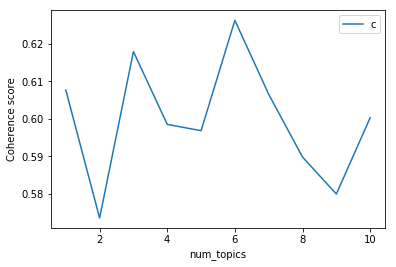

In [26]:
evaluate_graph(c_v_filtered)

In [27]:
# Build topic listings from each model.
def top_topics(lda, num_words=20):
    str_topics = []
    for topic in lda.state.get_lambda():
        topic = topic / topic.sum()  # normalize to probability distribution
        bestn = matutils.argsort(topic, topn=num_words, reverse=True)
        beststr = [lda.id2word[_id] for _id in bestn]
        str_topics.append(beststr)
    return str_topics

def get_super_topic(trained_models):
    model_topics = {}
    super_topic = set()
    for num_topics, model in trained_models.items():
        topics_as_topn_terms = top_topics(model)
        model_topics[num_topics] = topics_as_topn_terms
        super_topic.update(itertools.chain.from_iterable(topics_as_topn_terms))
    print("Number of relevant terms: %d" % len(super_topic))
    return super_topic, model_topics

In [28]:
super_topic, model_topics = get_super_topic(lm_filtered)
print(super_topic)

Number of relevant terms: 1616
{'falecer', 'despesa', 'taubate', 'tupã', 'imposto', 'mercantil', 'mauá', 'resp', 'pref', 'reduzida', 'jovem', 'volume', 'general', 'mercadoria', 'pensão', 'doença', 'governo', 'distorção', 'viagem', 'daee', 'higiene', 'prejuízo_vencer', 'serviço', 'itupeva', 'ângulo', 'audiência', 'finalidade', 'área_terra', 'luz', 'aula_aula', 'regularização', 'moeda_moeda', 'gratificar', 'nistração', 'jundiai_santo', 'thiago', 'objeto_aquisição', 'protocolo_apenso', 'cláusula', 'bombeiro', 'quant', 'fundações', 'brasil', 'bold', 'executivo', 'renovar', 'tecnologia', 'cond', 'mirassol', 'campinas_campina', 'parecer', 'sábado_janeiro', 'contrário', 'sabor', 'usp', 'receita_exame', 'apresentar', 'limpeza', 'frango', 'butantã_butantã', 'ativo', 'poço', 'norma', 'josé', 'equipar', 'cópia_receita', 'san', 'silva', 'exercer', 'concedendo', 'seca', 'contestar_lançar', 'corr', 'final', 'rocha', 'corrente', 'natureza', 'fazenda', 'candidato', 'deferidos', 'unanimidade', 'adminis

In [29]:
%%time
# Now estimate the probabilities for the CoherenceModel

cm = CoherenceModel(
    topics=[super_topic], texts=train_texts,
    dictionary=dictionary_filtered, coherence='c_v')
cm.estimate_probabilities()

2017-07-30 23:35:33,347 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-07-30 23:36:40,492 : INFO : 278 batches submitted to accumulate stats from 17792 documents (-648053 virtual)
2017-07-30 23:36:41,631 : INFO : 283 batches submitted to accumulate stats from 18112 documents (-649734 virtual)
2017-07-30 23:36:42,386 : INFO : 286 batches submitted to accumulate stats from 18304 documents (-650496 virtual)
2017-07-30 23:36:44,241 : INFO : 292 batches submitted to accumulate stats from 18688 documents (-652073 virtual)
2017-07-30 23:36:44,257 : INFO : 293 batches submitted to accumulate stats from 18752 documents (-652061 virtual)
2017-07-30 23:36:44,900 : INFO : 295 batches submitted to accumulate stats from 18880 documents (-652009 virtual)
2017-07-30 23:36:45,770 : INFO : 300 batches submitted to accumulate stats from 19200 documents (-654639 virtual)
2017-07-30 23:37:29,372 : INFO : 495 batches submitted

Wall time: 2min 24s


In [30]:
cm.get_coherence_per_topic()

[0.74330619010648447]

In [31]:
best_model_filtered.save('mp_model_60topics.lda')

2017-07-30 23:50:19,330 : INFO : saving LdaState object under mp_model_60topics.lda.state, separately None
2017-07-30 23:50:19,414 : INFO : saved mp_model_60topics.lda.state
2017-07-30 23:50:19,430 : INFO : saving LdaModel object under mp_model_60topics.lda, separately ['expElogbeta', 'sstats']
2017-07-30 23:50:19,432 : INFO : storing np array 'expElogbeta' to mp_model_60topics.lda.expElogbeta.npy
2017-07-30 23:50:19,444 : INFO : not storing attribute dispatcher
2017-07-30 23:50:19,446 : INFO : not storing attribute state
2017-07-30 23:50:19,447 : INFO : not storing attribute id2word
2017-07-30 23:50:19,455 : INFO : saved mp_model_60topics.lda


In [32]:
%%time
import numpy as np
# Next we perform the coherence evaluation for each of the models.
# Since we have already precomputed the probabilities, this simply
# involves using the accumulated stats in the `CoherenceModel` to
# perform the evaluations, which should be pretty quick.

coherences = {}
for num_topics, topics in model_topics.items():
    cm.topics = topics

    # We evaluate at various values of N and average them. This is a more robust,
    # according to: http://people.eng.unimelb.edu.au/tbaldwin/pubs/naacl2016.pdf
    coherence_at_n = {}
    for n in (20, 15, 10, 5):
        cm.topn = n
        topic_coherences = cm.get_coherence_per_topic()
        #print('coherence per topic for', n, 'topics', topic_coherences)
        
        # Let's record the coherences for each topic, as well as the aggregated
        # coherence across all of the topics.
        coherence_at_n[n] = (topic_coherences, cm.aggregate_measures(topic_coherences))
        #print('coherence at', n, 'topics', cm.aggregate_measures(topic_coherences))
        
    topic_coherences, avg_coherences = zip(*coherence_at_n.values())
    avg_topic_coherences = np.vstack(topic_coherences).mean(0)
    avg_coherence = np.mean(avg_coherences)
    print("Avg coherence for num_topics=%d: %.5f" % (num_topics, avg_coherence))
    coherences[num_topics] = (avg_topic_coherences, avg_coherence)

Avg coherence for num_topics=9: 0.59385
Avg coherence for num_topics=19: 0.55083
Avg coherence for num_topics=29: 0.59179
Avg coherence for num_topics=39: 0.55900
Avg coherence for num_topics=49: 0.57397
Avg coherence for num_topics=59: 0.59820
Avg coherence for num_topics=69: 0.58752
Avg coherence for num_topics=79: 0.56632
Avg coherence for num_topics=89: 0.56771
Avg coherence for num_topics=99: 0.58261
Wall time: 2min 52s


In [33]:
# Print the coherence rankings
avg_coherence = [(num_topics, avg_coherence) for num_topics, (_, avg_coherence) in coherences.items()]
ranked = sorted(avg_coherence, key=lambda tup: tup[1], reverse=True)
print("Ranked by average '%s' coherence:\n" % cm.coherence)
for item in ranked:
    print("num_topics=%d:\t%.4f" % item)
print("\nBest: %d" % ranked[0][0])

Ranked by average 'c_v' coherence:

num_topics=59:	0.5982
num_topics=9:	0.5939
num_topics=29:	0.5918
num_topics=69:	0.5875
num_topics=99:	0.5826
num_topics=49:	0.5740
num_topics=89:	0.5677
num_topics=79:	0.5663
num_topics=39:	0.5590
num_topics=19:	0.5508

Best: 59


In [34]:
best_model_filtered.print_topics()

2017-07-30 23:53:28,771 : INFO : topic #16 (0.012): 0.353*"merc" + 0.146*"merc_merc" + 0.039*"arr" + 0.030*"arr_merc" + 0.020*"milimetro" + 0.010*"digital" + 0.009*"cação" + 0.007*"tecnologia" + 0.006*"diâmetro" + 0.006*"macro"
2017-07-30 23:53:28,772 : INFO : topic #27 (0.013): 0.276*"santos" + 0.080*"santos_santos" + 0.039*"guaruja" + 0.026*"preto" + 0.022*"ribeirão" + 0.009*"guaruja_guaruja" + 0.008*"cacapava" + 0.007*"prot" + 0.007*"creci" + 0.006*"prati"
2017-07-30 23:53:28,774 : INFO : topic #8 (0.013): 0.037*"ano" + 0.029*"exemplar" + 0.020*"disponibilidade" + 0.019*"jornal" + 0.018*"máximo" + 0.018*"edição" + 0.016*"período_exemplar" + 0.015*"cubatão" + 0.015*"reclamar" + 0.015*"domicílio"
2017-07-30 23:53:28,776 : INFO : topic #37 (0.013): 0.046*"horário" + 0.027*"feira" + 0.025*"maua" + 0.021*"região" + 0.014*"informar" + 0.014*"grplqjr" + 0.013*"unidade" + 0.011*"registro" + 0.011*"maiores" + 0.011*"autoridade"
2017-07-30 23:53:28,777 : INFO : topic #46 (0.013): 0.039*"decre

[(16,
  '0.353*"merc" + 0.146*"merc_merc" + 0.039*"arr" + 0.030*"arr_merc" + 0.020*"milimetro" + 0.010*"digital" + 0.009*"cação" + 0.007*"tecnologia" + 0.006*"diâmetro" + 0.006*"macro"'),
 (27,
  '0.276*"santos" + 0.080*"santos_santos" + 0.039*"guaruja" + 0.026*"preto" + 0.022*"ribeirão" + 0.009*"guaruja_guaruja" + 0.008*"cacapava" + 0.007*"prot" + 0.007*"creci" + 0.006*"prati"'),
 (8,
  '0.037*"ano" + 0.029*"exemplar" + 0.020*"disponibilidade" + 0.019*"jornal" + 0.018*"máximo" + 0.018*"edição" + 0.016*"período_exemplar" + 0.015*"cubatão" + 0.015*"reclamar" + 0.015*"domicílio"'),
 (37,
  '0.046*"horário" + 0.027*"feira" + 0.025*"maua" + 0.021*"região" + 0.014*"informar" + 0.014*"grplqjr" + 0.013*"unidade" + 0.011*"registro" + 0.011*"maiores" + 0.011*"autoridade"'),
 (46,
  '0.039*"decreto" + 0.032*"portaria" + 0.024*"lei" + 0.019*"sergipe" + 0.018*"abril" + 0.014*"providência" + 0.014*"criação" + 0.014*"aracaju" + 0.013*"maio" + 0.013*"vigor"'),
 (18,
  '0.084*"cruz" + 0.077*"mogi" + 0

In [35]:
pyLDAvis.gensim.prepare(best_model_filtered, corpus_filtered, dictionary_filtered)

2017-07-30 23:53:45,614 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-30 23:54:53,568 : DEBUG : 41283/41283 documents converged within 400 iterations
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
48     6.995323        1       1 -0.019974 -0.082511
23     5.105134        1       2 -0.054067 -0.072060
9      4.957114        1       3 -0.292148  0.025394
15     4.385847        1       4 -0.028357  0.237570
4      3.716659        1       5 -0.008896  0.057932
41     3.448241        1       6  0.188456  0.120036
28     3.148140        1       7  0.129475  0.168736
29     3.041841        1       8 -0.024751 -0.140017
1      2.958355        1       9  0.017284  0.042521
55     2.882560        1      10 -0.267327  0.025200
31     2.759984        1      11 -0.272272  0.012208
20     2.738964        1      12 -0.139757  0.068498
45     2.634695        1      13 -0.293074  0.002398
19     2.523789        1      14  0.034907  0.075194
34     2.274713        1      15  0.025056  0.059902
14     2.254869        1      16 -0.049990 -0.007779
6      2.078651        1      17 -0.017217  0.027622
44     2.036913        1      18 -0.065194  0.145934
57     2.003207        1      19 -0.059758  0.111213
10     1.780299        1      20  0.108833  0.145944
30     1.686031        1      21 -0.014489 -0.203717
39     1.664591        1      22 -0.025749 -0.094327
46     1.642996        1      23  0.047017  0.190091
35     1.519233        1      24 -0.011055  0.216396
47     1.450262        1      25 -0.199771 -0.027136
53     1.443965        1      26  0.058033  0.072952
33     1.433286        1      27  0.112648  0.028919
21     1.281874        1      28 -0.244147  0.019649
25     1.228165        1      29  0.011941 -0.026729
59     1.153848        1      30  0.129022  0.114720
17     1.153353        1      31  0.059128 -0.127409
42     1.146080        1      32  0.038888  0.031954
7      1.017722        1      33  0.151722 -0.110480
54     0.999757        1      34  0.025576 -0.189141
52     0.929419        1      35  0.006458  0.090074
24     0.928993        1      36  0.152356 -0.039157
51     0.918372        1      37 -0.077126 -0.087896
36     0.885806        1      38  0.047679 -0.030612
11     0.879075        1      39  0.066430 -0.005285
13     0.878558        1      40 -0.009330 -0.074849
40     0.856653        1      41  0.067647  0.066501
22     0.824480        1      42 -0.018065  0.086779
32     0.817168        1      43  0.121700  0.014788
0      0.808152        1      44  0.037675 -0.088490
12     0.697272        1      45  0.043032 -0.087453
43     0.691188        1      46  0.067605 -0.130746
56     0.684946        1      47  0.085139 -0.054572
2      0.662390        1      48  0.060146 -0.031669
5      0.661169        1      49 -0.083377  0.050396
3      0.659155        1      50  0.120390  0.067765
26     0.634896        1      51  0.094733 -0.072365
38     0.605661        1      52 -0.170368 -0.075233
50     0.559732        1      53  0.062184 -0.031303
58     0.466772        1      54 -0.011820 -0.079468
49     0.450513        1      55  0.058768 -0.009354
16     0.438281        1      56  0.056937 -0.101765
8      0.429422        1      57  0.005547 -0.035108
18     0.398638        1      58  0.048736 -0.078808
37     0.383811        1      59  0.086912 -0.091396
27     0.303019        1      60  0.030019 -0.090454, topic_info=      Category          Freq                   Term         Total  loglift  \
term                                                                         
186    Default  24360.000000                    lei  24360.000000  30.0000   
4606   Default   4202.000000                   merc   4202.000000  29.0000   
5660   Default  11097.000000              candidato  11097.000000  28.0000   
310    Default  17137.000000                   item  17137.000000  27.0000   
67     Default  28644.000000                  valor  28644.000000  26.0000   
129    Default   6270.000000                  total   6270.000000  25.0000   
592    Default   9711.000000                  p